In [ ]:
!pip install yellowbrick

In [31]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
plt.style.use('fivethirtyeight')

# 통계분석
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# 차원축소
from sklearn.preprocessing import *
from sklearn.decomposition import TruncatedSVD, PCA

# 군집화
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster 
from sklearn_extra.cluster import KMedoids
from yellowbrick.cluster import KElbowVisualizer

# 실루엣 분석 metric 값을 구하기 위한 API 추가
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs

import warnings
warnings.filterwarnings('ignore')

In [13]:
import os

# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

## 군집화
- 군집화 과정 역시, 최종 ppt에서 제시한 데이터를 활용하지 못해(통계청 데이터) 결과가 상이할 수 있음을 참고하자.
- KMaens, GMM, DBSCAN, Hierarchy Clustering을 진행한다.
- 실루엣계수를 비교하여 최종적으로 KMeans Clustering 기법을 선택하여 최종 서비스 대상 군집으로 선택한다.

In [14]:
def silhouette_avg(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    return cluster_labels, yticks, silhoutte_avg

### KMeans
- k가 2 혹은 3일 경우 가장 안정적인 실루엣 계수 분포를 보인다.
- 2개는 나누어지는 군집의 개수가 너무 적다고 판단하여 3개로 최종 결정하였다.

In [15]:
pca_result = pd.read_csv('./data_to_model/data_after_pca.csv', index_col=0)

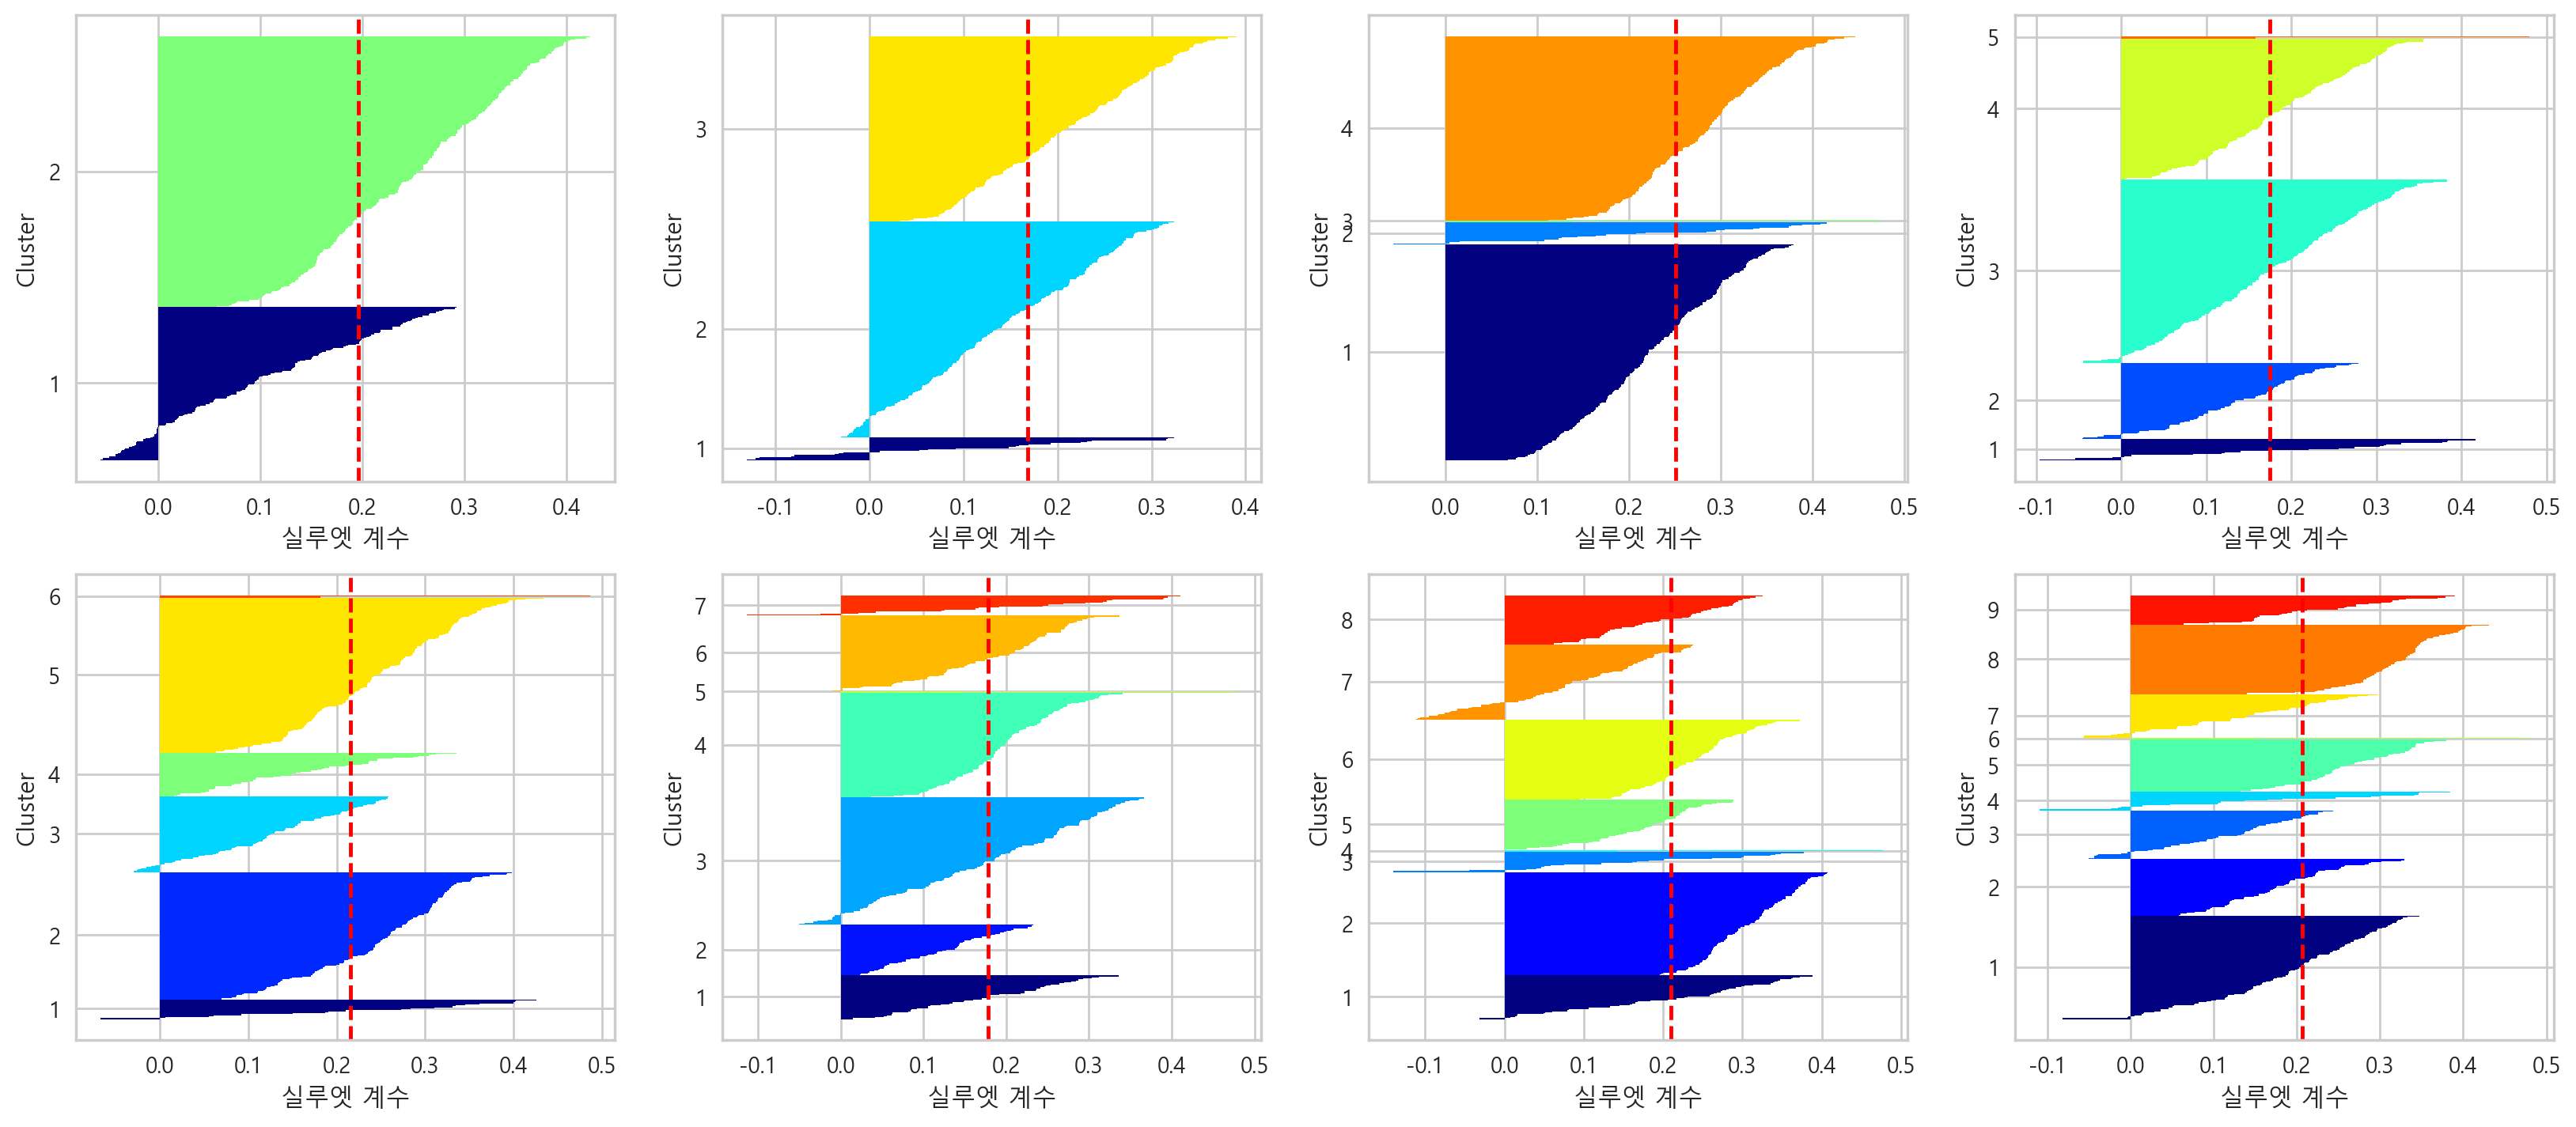

In [16]:
# 군집의 개수를 2~9까지 바꿔가며 최적의 군집 개수를 선택한다.
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

nrows, ncols = 2, 4
fig, ax = plt.subplots(nrows=nrows,
                       ncols=ncols,
                       figsize=(18,8))
for i, n_cluster in enumerate(n_clusters):
    kmeans = KMeans(n_clusters=n_cluster,
                    init='k-means++',
                    max_iter=300,
                    random_state=0)
    kmeans.fit(pca_result)

    
    plt.subplot(nrows, ncols, i+1)
    pca_result['cluster'] = kmeans.labels_
    cluster_labels, yticks, silhoutte_score = silhouette_avg(pca_result, kmeans.labels_)
    
    plt.axvline(silhoutte_score, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('Cluster')
    plt.xlabel('실루엣 계수')
plt.show()

In [ ]:
# kmeans = KMeans()
# visualizer = KElbowVisualizer(kmeans, k=(1,10))
# visualizer.fit(pca_result)

In [40]:
kmeans = KMeans(n_clusters=3,
                init='k-means++',
                max_iter=300,
                random_state=0)
kmeans.fit(pca_result)

pca_result['cluster'] = kmeans.labels_

In [41]:
# 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(pca_result.iloc[:,:-1], pca_result['cluster'])
print('silhouette_samples() return 값의 shape: ' , score_samples.shape)

# 실루엣 계수 컬럼 추가
pca_result['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(pca_result.iloc[:,:-2], pca_result['cluster'])
print('Data의 그룹별 Silhouette Analysis Score:  {0:.3f}'.format(average_score))

print(pca_result.groupby('cluster')['silhouette_coeff'].mean())

silhouette_samples() return 값의 shape:  (426,)
Data의 그룹별 Silhouette Analysis Score:  0.158
cluster
0    0.081532
1    0.208895
2    0.139626
Name: silhouette_coeff, dtype: float64


In [43]:
pca_result[['cluster', 'silhouette_coeff']]

cluster  silhouette_coeff
가락1동        2          0.071798
가락2동        2          0.192430
가락본동        2          0.266139
가리봉동        0         -0.124566
가산동         2          0.192119
...       ...               ...
효창동         1          0.323358
후암동         1          0.238373
휘경1동        1          0.239724
휘경2동        2          0.077964
흑석동         2          0.256154

[426 rows x 2 columns]

In [44]:
pca_result[pca_result['cluster']==0]

인구가 비교적 적은 지역  1인 세대 및 20~30대 남녀가 많은 지역  \
가리봉동              5.988013                  2.422976   
가회동               6.514826                 -0.552856   
개포1동              7.043978                 -1.248807   
광희동               5.090384                  1.642227   
남영동               4.339375                  1.462176   
둔촌1동             27.154264                 -0.787448   
명동                8.245085                  0.339135   
반포본동             18.459850                 -2.219277   
사직동               2.762410                 -0.162976   
삼성1동              4.414021                 -0.261014   
삼청동               8.825786                 -0.603611   
소공동               9.425018                 -0.340521   
신당동               3.793019                  1.213323   
신사동(강남구)          3.234968                 -0.162372   
을지로동              8.353391                  1.228787   
이태원1동             4.702637                  0.731779   
이화동               4.017286                  1.117104   
장충동               5.776721                  0.880575   
종로1.2.3.4가동       4.241933                  1.620171   
종로5.6가동           5.134197                  1.312125   
창신1동              5.993034                  0.593889   
필동                6.352802                  0.739571   
회현동               5.923497                  0.153998   

             미취학 및 초등학생, 젊은 세대가 많은 지역  도시농업 체험 프로그램이 많은 지역  \
가리봉동                        -0.892778            -0.603970   
가회동                         -0.431884            -0.512189   
개포1동                        -0.463502            -0.603970   
광희동                         -0.015449             2.402813   
남영동                         -0.599459            -0.572015   
둔촌1동                         1.129912            -0.603970   
명동                          -0.681317            -0.547722   
반포본동                         0.576948            -0.535675   
사직동                         -0.182621            -0.320981   
삼성1동                         0.256955            -0.350432   
삼청동                         -0.729985            -0.208339   
소공동                          1.459274             2.441604   
신당동                         -0.193139            -0.603970   
신사동(강남구)                    -0.106298            -0.526522   
을지로동                         0.455000            -0.488608   
이태원1동                       -0.309738             3.148011   
이화동                         -0.009971            -0.313376   
장충동                          0.336047            -0.603970   
종로1.2.3.4가동                 -0.873673             7.659955   
종로5.6가동                     -0.058401            -0.565564   
창신1동                        -0.885046            -0.603970   
필동                          -0.011632            -0.582337   
회현동                         -1.004189            -0.603970   

             도시 농업 체험 프로그램이 적은 지역  예상 수요가 낮은 지역  유치원이 많은 지역  납품할 업체가 많은 지역  \
가리봉동                    -0.895200      1.654339   -1.617270       1.205942   
가회동                     -0.120254     -1.047619   -0.628032      -0.480477   
개포1동                    -0.895200      3.369066   -0.770789       1.302895   
광희동                     -0.823443     -1.965703   -2.707367       0.567159   
남영동                     -0.625388     -0.852558   -2.752061      -1.060833   
둔촌1동                    -0.895200      4.653625   -1.057692      -0.906868   
명동                      -0.420271     -3.017376   -1.553779      -0.779059   
반포본동                    -0.318552      2.931978   -0.706421       0.014572   
사직동                      1.494207     -2.222048   -0.616986      -0.845174   
삼성1동                     1.245533     -2.108941   -0.639099      -0.881862   
삼청동                      2.445292     -0.550482   -2.718119      -1.868950   
소공동                     -0.495916     -2.303914   -0.626832      -0.906811   
신당동                     -0.895200      0.911549   -0.551408      -1.176238   
신사동(강남구)                -0.241271     -2.578814   -0.656875      -0.677075   
을지로동     

In [45]:
pca_result[pca_result['cluster']==1]

인구가 비교적 적은 지역  1인 세대 및 20~30대 남녀가 많은 지역  미취학 및 초등학생, 젊은 세대가 많은 지역  \
가양2동       1.047005                  1.083287                 -1.408682   
가양3동       0.843889                  0.713252                 -0.915505   
갈현1동       0.716600                  0.246985                 -0.359258   
개봉2동       0.524726                  0.072089                 -1.188643   
개봉3동       2.363159                  0.225166                 -1.169158   
...             ...                       ...                       ...   
황학동        1.497364                  0.953995                  0.501807   
회기동        2.274079                  1.216488                  0.852462   
효창동        2.345512                 -0.479760                  0.577316   
후암동        0.321338                  0.281964                  0.023078   
휘경1동       1.008292                  0.798911                  0.616412   

      도시농업 체험 프로그램이 많은 지역  도시 농업 체험 프로그램이 적은 지역  예상 수요가 낮은 지역  유치원이 많은 지역  \
가양2동            -0.423399              0.629442      1.696873    0.268370   
가양3동            -0.543666             -0.386026      2.627217    0.592556   
갈현1동            -0.557469             -0.502570      0.061798   -1.787539   
개봉2동            -0.585828             -0.742023      0.840585   -0.833727   
개봉3동            -0.259340              2.014666      1.007719    0.542738   
...                   ...                   ...           ...         ...   
황학동             -0.578979             -0.684186     -0.061807   -2.743111   
회기동             -0.599694             -0.859098     -1.542450    1.067521   
효창동             -0.281735              1.825577      1.434872   -1.637105   
후암동             -0.581655             -0.706781      0.513579    0.026451   
휘경1동            -0.580306             -0.695398      0.367425   -1.796529   

      납품할 업체가 많은 지역  초등학교가 많은 지역  미세먼지 오염이 비교적 심한 곳  비교적 공기오염이 덜한 곳  \
가양2동      -1.218569    -0.759118          -0.171527        0.329450   
가양3동      -0.794429    -1.030091          -0.163867        0.349306   
갈현1동       0.462257    -0.846310          -1.718142        0.554117   
개봉2동      -1.179873    -2.010229          -0.045331       -1.171743   
개봉3동       0.552335     1.491110           0.233937       -0.447816   
...             ...          ...                ...             ...   
황학동        0.869033     0.165824          -0.512614        1.285343   
회기동       -0.775615     0.786911          -0.339561        1.733936   
효창동       -0.565325     1.236236           0.979602        0.857256   
후암동       -1.734819     0.757831           0.651105        0.005716   
휘경1동      -1.518520    -1.086658          -0.544548        1.181152   

      사업체가 적은 곳  상가 매출이 많은 곳  사업체가 많은 곳  cluster  silhouette_coeff  
가양2동   2.078350     0.364667   0.547525        1          0.313082  
가양3동   1.356460     0.956231   1.453624        1          0.294131  
갈현1동   0.391383    -0.131930  -0.088055        1          0.235814  
개봉2동   0.319594     0.573087  -0.644746        1          0.192983  
개봉3동   0.980428    -0.449858   0.713026        1          0.263964  
...         ...          ...        ...      ...               ...  
황학동    0.796391    -0.815030   0.870077        1          0.256535  
회기동    0.240349     0.701839   0.041254        1          0.155631  
효창동    1.932959     1.239572  -0.249081        1          0.323358  
후암동    0.983336     0.248618   0.007313        1          0.238373  
휘경1동   0.515704     0.184295  -1.189764        1          0.239724  

[207 rows x 16 columns]

In [46]:
pca_result[pca_result['cluster']==2]

인구가 비교적 적은 지역  1인 세대 및 20~30대 남녀가 많은 지역  미취학 및 초등학생, 젊은 세대가 많은 지역  \
가락1동      -1.385345                 -1.803981                  0.717072   
가락2동      -2.186509                 -0.903525                  0.560421   
가락본동      -1.414738                  0.052435                  0.375364   
가산동       -0.789125                  2.595896                  1.082431   
가양1동      -2.318086                  1.548118                  1.721556   
...             ...                       ...                       ...   
화곡8동      -1.303562                  0.393687                 -0.181354   
화곡본동      -2.732407                  0.637663                  0.471860   
화양동       -0.253937                  3.047263                  1.390986   
휘경2동      -1.530182                  0.590519                  0.310702   
흑석동       -2.307336                 -0.385579                  0.071812   

      도시농업 체험 프로그램이 많은 지역  도시 농업 체험 프로그램이 적은 지역  예상 수요가 낮은 지역  유치원이 많은 지역  \
가락1동            -0.524023             -0.220172      0.236120    0.070813   
가락2동            -0.235092              2.219405     -0.475947    1.330384   
가락본동            -0.435469              0.527534     -2.229353    0.582526   
가산동             -0.591722             -0.791785     -3.424138   -1.776846   
가양1동            -0.313918              1.553839     -3.010442    0.328893   
...                   ...                   ...           ...         ...   
화곡8동            -0.508575             -0.089737     -0.432328   -1.809629   
화곡본동            -0.195618              2.552704      0.676481    1.319406   
화양동             -0.603970             -0.895200     -1.719662   -0.052320   
휘경2동            -0.569024             -0.600132     -0.284002    0.963473   
흑석동             -0.326382              1.448598     -0.870335    2.216524   

      납품할 업체가 많은 지역  초등학교가 많은 지역  미세먼지 오염이 비교적 심한 곳  비교적 공기오염이 덜한 곳  \
가락1동       1.875716     1.158075          -0.094965       -0.641092   
가락2동       0.320708    -0.312788          -0.168193       -0.830915   
가락본동       0.817341     0.508024           0.005528       -0.380592   
가산동        0.331809    -0.905590           0.476478        0.258452   
가양1동      -0.996485    -0.853734           1.167873       -0.515066   
...             ...          ...                ...             ...   
화곡8동       2.176759    -0.597310          -0.641999       -0.127390   
화곡본동       1.279092    -0.164436          -0.736848       -0.556358   
화양동        0.192378    -0.313606          -0.167326        1.125804   
휘경2동      -0.892087    -0.073695          -0.956301        0.113796   
흑석동        1.203622    -0.099393          -0.048098       -0.993208   

      사업체가 적은 곳  상가 매출이 많은 곳  사업체가 많은 곳  cluster  silhouette_coeff  
가락1동  -0.856961     1.575414   0.946321        2          0.071798  
가락2동  -0.355864    -0.024727   0.723038        2          0.192430  
가락본동  -1.581389    -0.395351   0.845590        2          0.266139  
가산동   -5.306620     0.018415   0.860085        2          0.192119  
가양1동  -2.981474    -1.467298   0.880513        2          0.252741  
...         ...          ...        ...      ...               ...  
화곡8동   0.453706     0.201908  -0.440996        2          0.001190  
화곡본동   0.171774     0.796068  -0.089851        2          0.147620  
화양동   -1.398747     0.544927  -0.292616        2          0.117699  
휘경2동   0.643531    -0.511455  -0.173268        2          0.077964  
흑석동   -0.747234    -0.224324  -0.782854        2          0.256154  

[196 rows x 16 columns]

### GMM
- 군집의 개수가 2개일 경우 가장 최선
- 3개 이상이 될 경우, 실루엣 계수가 안정적이지 않다.
- 더불어, 군집을 2개로 나누는 것은 군집의 개수가 적다고 판단.

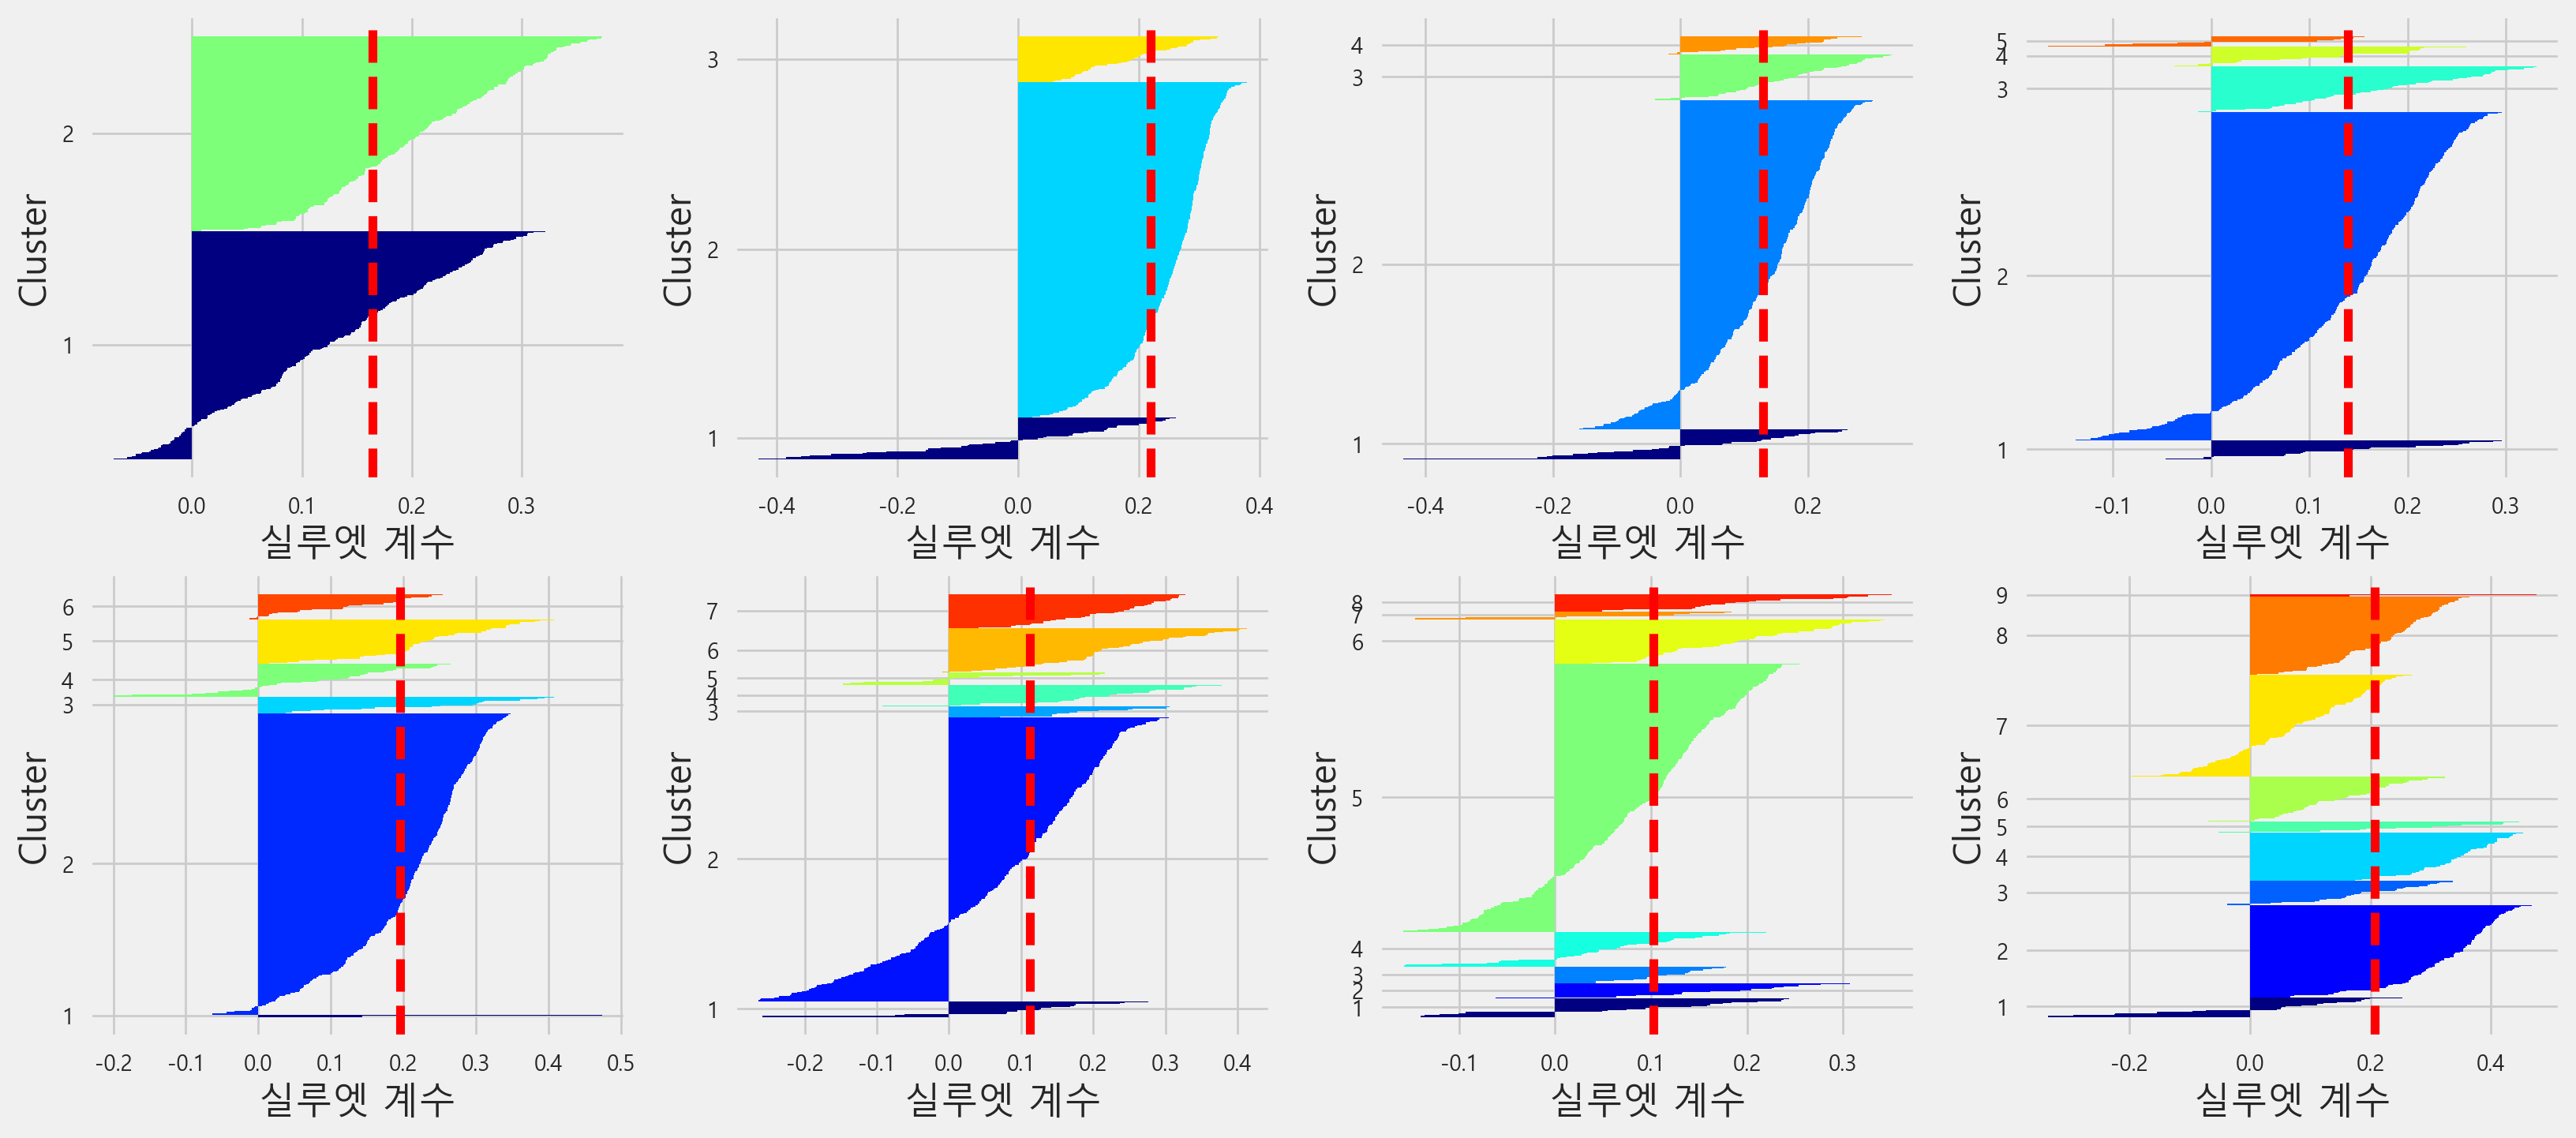

In [48]:
# 군집의 개수를 2~9까지 바꿔가며 최적의 군집 개수를 선택한다.
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

nrows, ncols = 2, 4
fig, ax = plt.subplots(nrows=nrows,
                       ncols=ncols,
                       figsize=(18,8))
for i, n_cluster in enumerate(n_clusters):
    gmm=GaussianMixture(n_components=n_cluster, random_state=0).fit(pca_result)
    gmm_cluster_label=gmm.predict(pca_result)

    plt.subplot(nrows, ncols, i+1)
    pca_result['cluster'] = gmm_cluster_label
    cluster_labels, yticks, silhoutte_score = silhouette_avg(pca_result, gmm_cluster_label)
    
    plt.axvline(silhoutte_score, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('Cluster')
    plt.xlabel('실루엣 계수')
plt.show()

In [50]:
gmm=GaussianMixture(n_components=2, random_state=0).fit(pca_result)
gmm_cluster_label=gmm.predict(pca_result)

pca_result['cluster_label']=gmm_cluster_label

In [52]:
# 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(pca_result.iloc[:,:-2], pca_result['cluster_label'])
print('silhouette_samples( ) return 값의 shape: ' , score_samples.shape)

# 실루엣 계수 컬럼 추가
pca_result['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(pca_result.iloc[:,:-2], pca_result['cluster_label'])
print('Data의 그룹별 Silhouette Analysis Score:  {0:.3f}'.format(average_score))

print(pca_result.groupby('cluster_label')['silhouette_coeff'].mean())

silhouette_samples( ) return 값의 shape:  (426,)
Data의 그룹별 Silhouette Analysis Score:  0.178
cluster_label
0    0.120553
1    0.228761
Name: silhouette_coeff, dtype: float64


### DBSCAN
- DBSCAN을 활용할 경우, 군집이 제대로 나누어지지 않음.

In [53]:
dbscan=DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_cluster_label=dbscan.fit_predict(pca_result)

pca_result['cluster_label']=dbscan_cluster_label
pca_result['cluster_label'].value_counts()

cluster_label
-1    426
Name: count, dtype: int64

### Hierarchical Clustering

- 다소 균등하게 군집이 나누어짐을 확인.
- KMeans에 비해, 실루엣 계수의 안정성이 떨어짐

In [55]:
clusters = linkage(y=pca_result, method='complete', metric='euclidean')
clusters.shape 

(425, 4)

In [56]:
cut_tree = fcluster(clusters, t=11, criterion='distance')
pca_result['cluster_label']=cut_tree # prediction

pca_result['cluster_label'].value_counts()

cluster_label
8    157
6    144
9     62
7     45
3     10
5      5
1      1
2      1
4      1
Name: count, dtype: int64

In [57]:
# 모든 개별 데이터에 실루엣 계수값을 구함.
score_samples = silhouette_score(pca_result.iloc[:,:-2], pca_result['cluster_label'])
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

# 실루엣 계수 컬럼 추가
pca_result['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(pca_result.iloc[:,:-2], pca_result['cluster_label'])
print('dpca_resultult 그룹별 Silhouette Analysis Score:{0:.3f}'.format(average_score))

print(pca_result.groupby('cluster_label')['silhouette_coeff'].mean())

silhouette_samples( ) return 값의 shape ()
dpca_resultult 그룹별 Silhouette Analysis Score:0.216
cluster_label
1    0.21597
2    0.21597
3    0.21597
4    0.21597
5    0.21597
6    0.21597
7    0.21597
8    0.21597
9    0.21597
Name: silhouette_coeff, dtype: float64


## 최종 군집 선택

다음의 분석으로부터 최종 군집과 그 특성들을 확인할 수 있다.

- 0번 군집 : 소득수준과 인구가 낮고 식당가도 없어 유동인구가 낮아보이며 주위에 대형마트의 비율이 높은 노년인구가 많은 외곽지역의 오래된 5일장  
- 1번 군집 :  소득수준과 인구가 높은 점포수가 적은 현대화된 시장 하지만 특이 품목을 파는 시장은 아님
- 2번 군집 :  도심 중심 업무 지구에 위치하고 젊은층의 인구가 많으며 주변에 대형마트가 적은 시장
- 3번 군집 :  규모와 시설이 낙후되지 않았지만 도보이용이 힘든 외곽의 주거 지구에 위치한 시장

**Note:** 본 과정은 최종 제출한 PPT와 데이터의 차이(통계청 제공 데이터(공개불가))가 있어 결과가 다르므로 데이터 분석의 흐름만 참고하도록 한다. 더불어, 통계청 제공 데이터의 원시데이터는 없으며, 이를 활용한 분석의 결과물이 존재하므로 data folder에 존재하는 data를 활용하여 이후의 분석을 진행해보도록 한다.

In [85]:
pca_result = pd.read_csv('./data_to_model/data_after_pca.csv', index_col=0)
pca_result.fillna(0, inplace=True)

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=0)
kmeans.fit(pca_result)

pca_result['cluster'] = kmeans.labels_

In [65]:
# 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(pca_result.iloc[:,:-1], pca_result['cluster'])
print('silhouette_samples() return 값의 shape: ' , score_samples.shape)

# 실루엣 계수 컬럼 추가
pca_result['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(pca_result.iloc[:,:-2], pca_result['cluster'])
print('Data의 그룹별 Silhouette Analysis Score:  {0:.3f}'.format(average_score))

print(pca_result.groupby('cluster')['silhouette_coeff'].mean())

silhouette_samples() return 값의 shape:  (426,)
Data의 그룹별 Silhouette Analysis Score:  0.164
cluster
0    0.128346
1    0.204379
2    0.306109
3    0.191950
Name: silhouette_coeff, dtype: float64


In [66]:
def histplot(data, row_num, col_num) :
    fig, ax = plt.subplots(ncols = col_num, figsize = (18,4))
    rep = int(len(data.columns) / col_num)
    
    for i in range(col_num) :
        sns.kdeplot(data.iloc[:, row_num + (rep * i)], ax = ax[i])
        ax[i].set_title(data.iloc[:, row_num + (rep * i)].name)

### 첫번째 Group

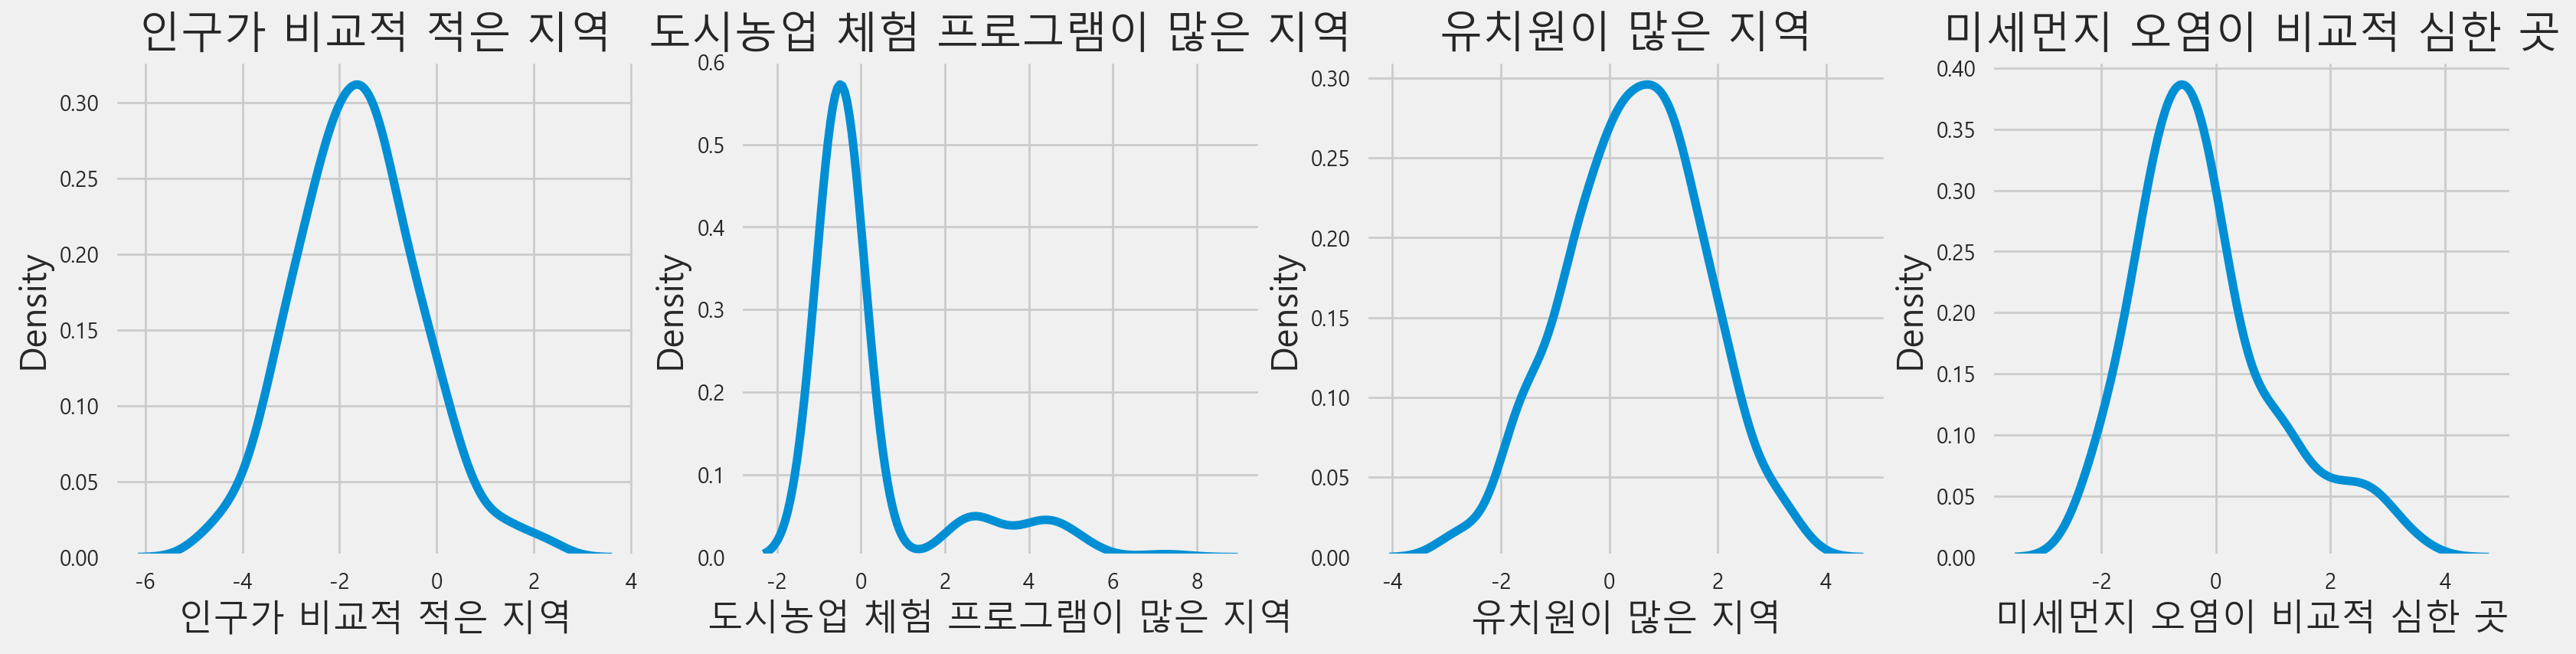

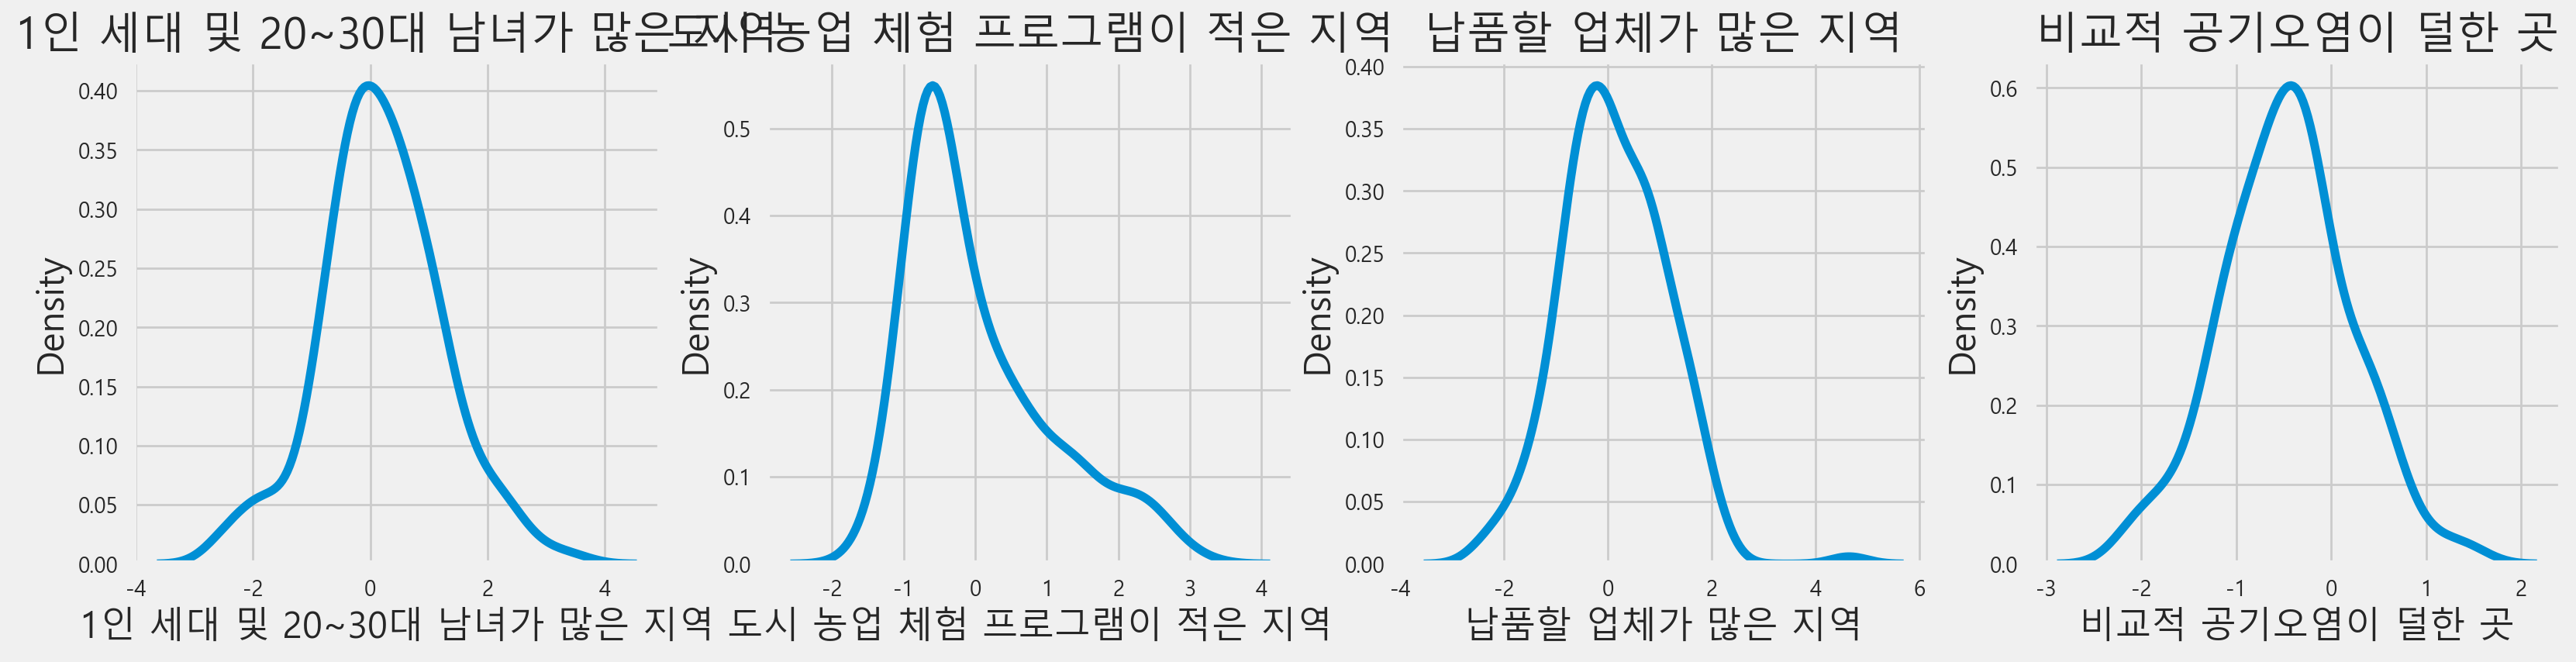

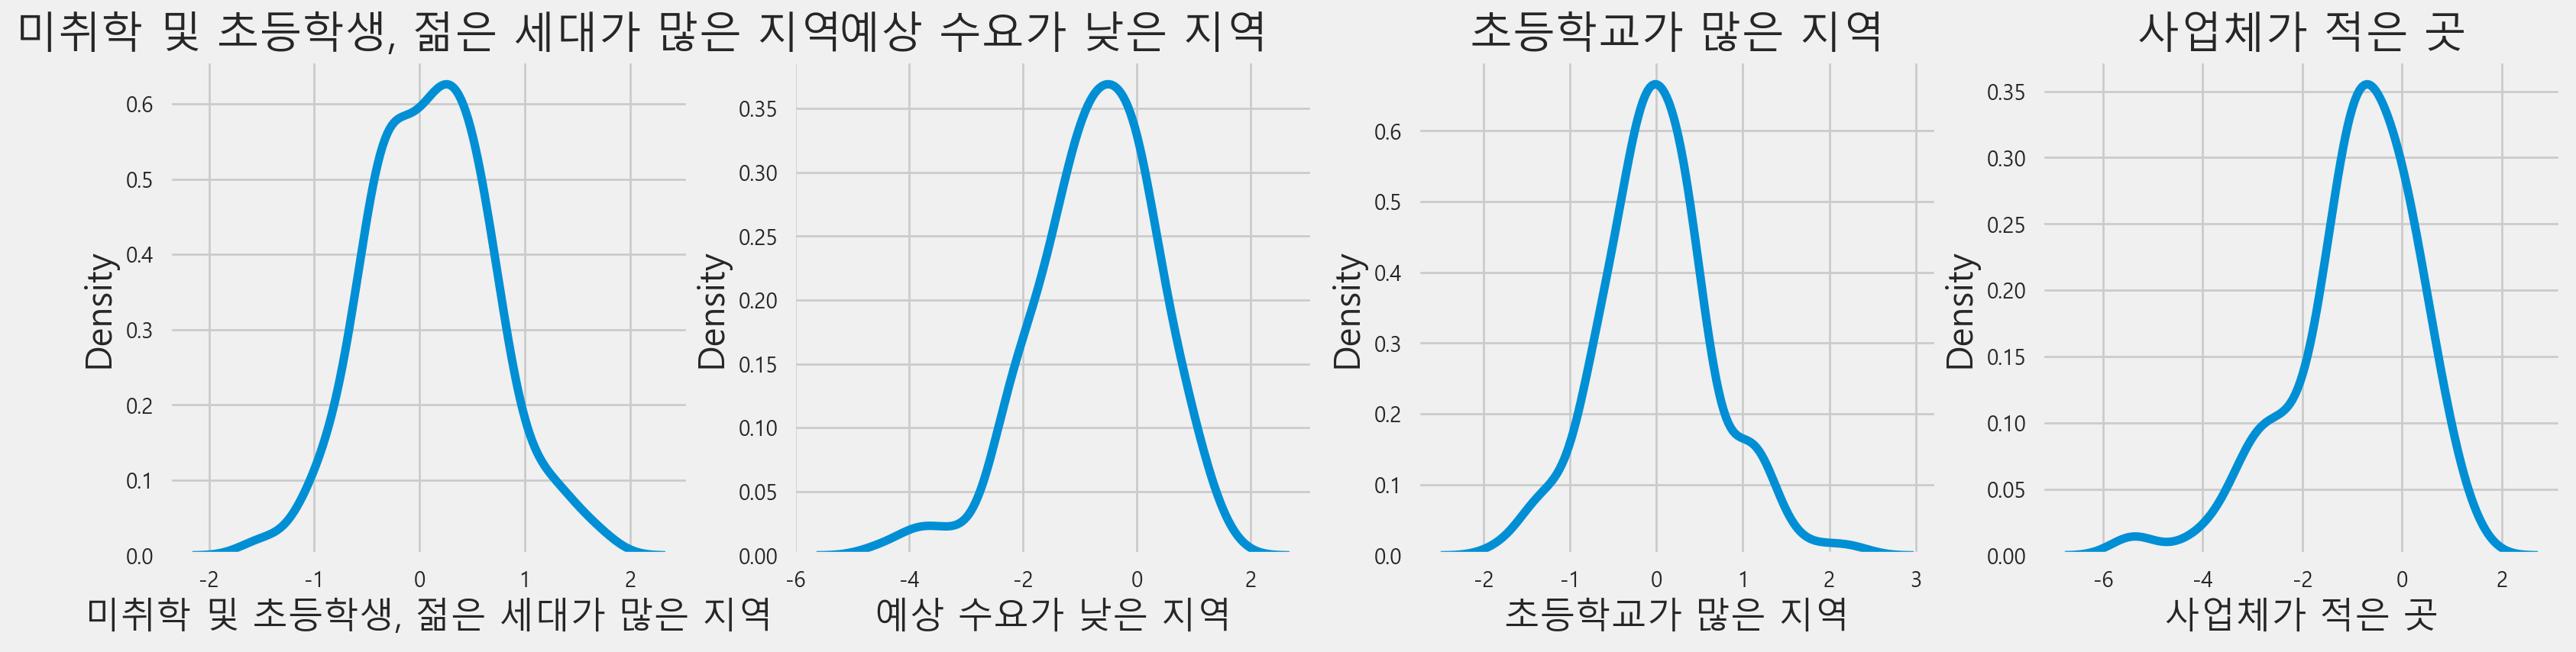

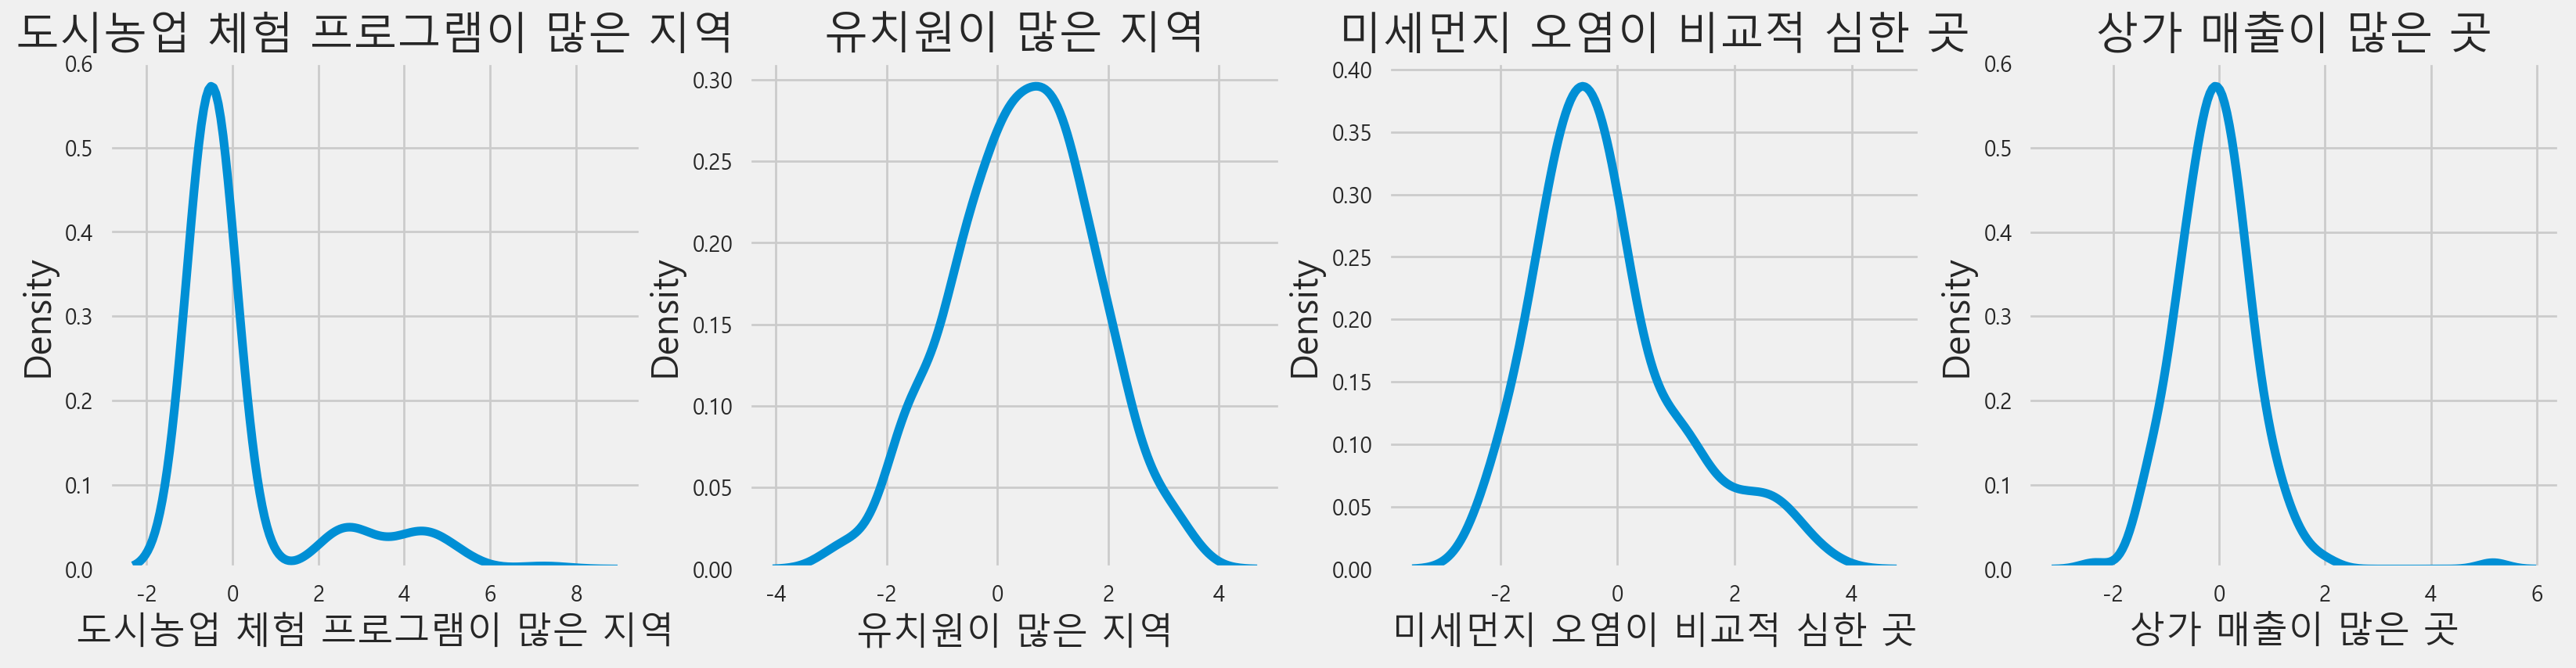

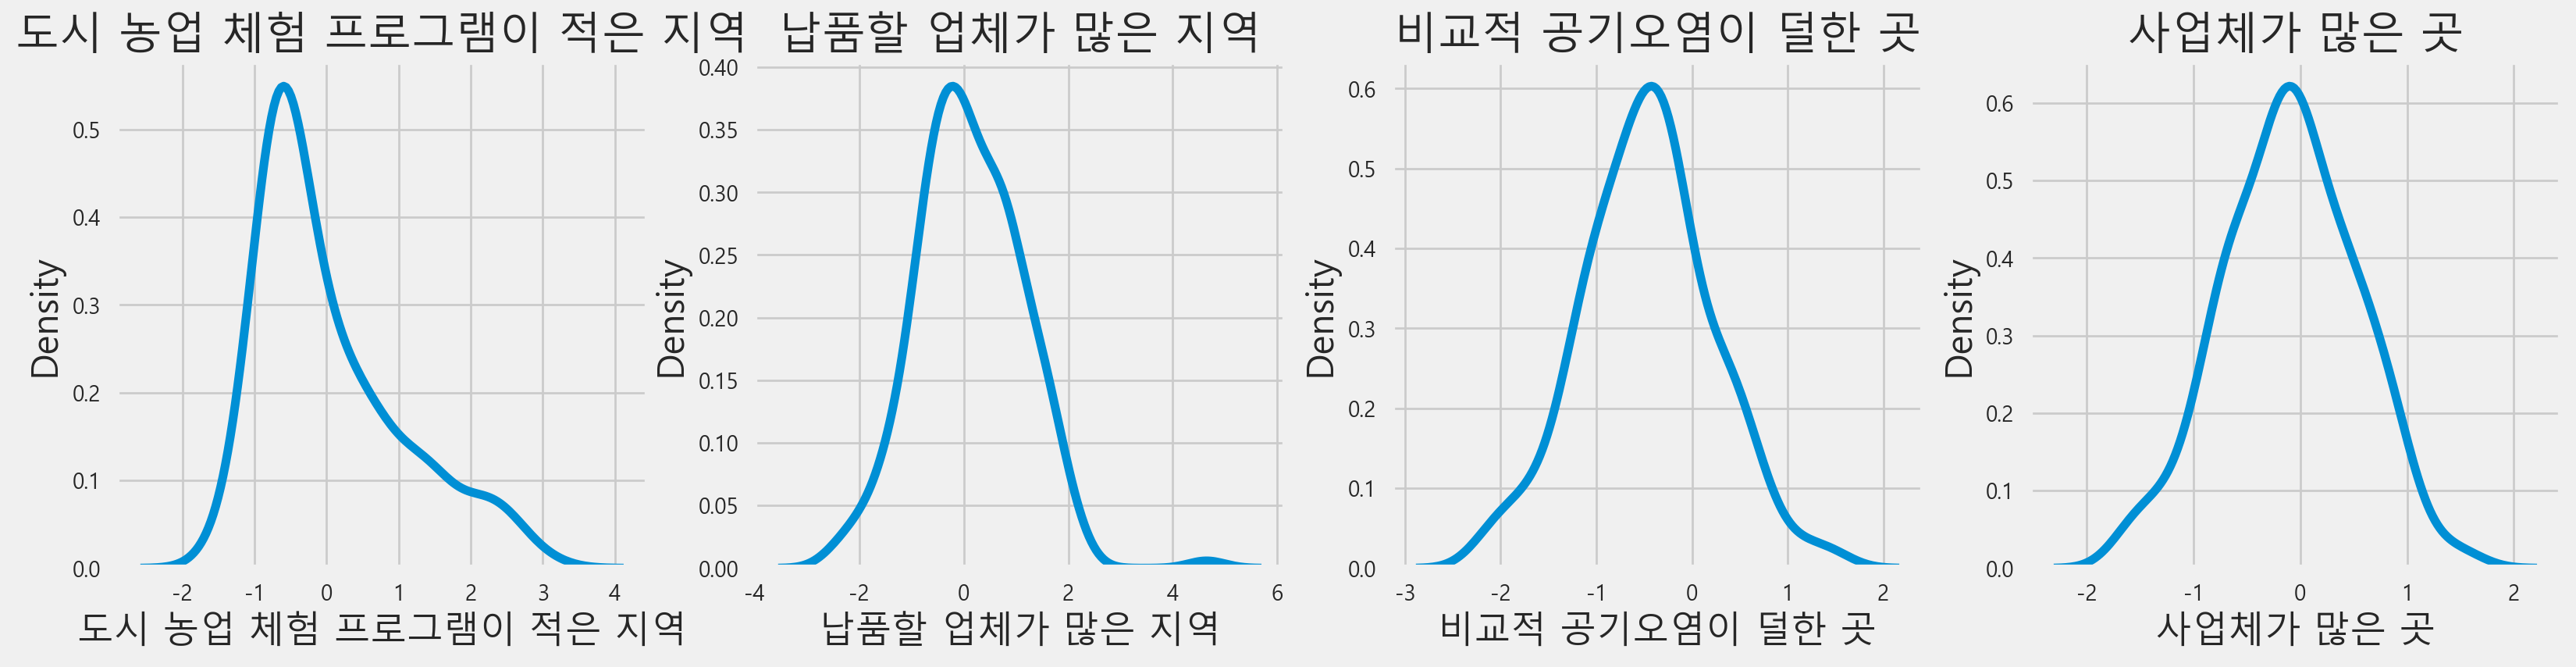

In [71]:
first_group = pca_result[pca_result['cluster'] == 0]
first_group.drop(['silhouette_coeff'], axis = 1, inplace = True)

for row_num in range(5) :
    histplot(first_group.drop(['cluster'], axis = 1), row_num, 4)

### 두번째 Group

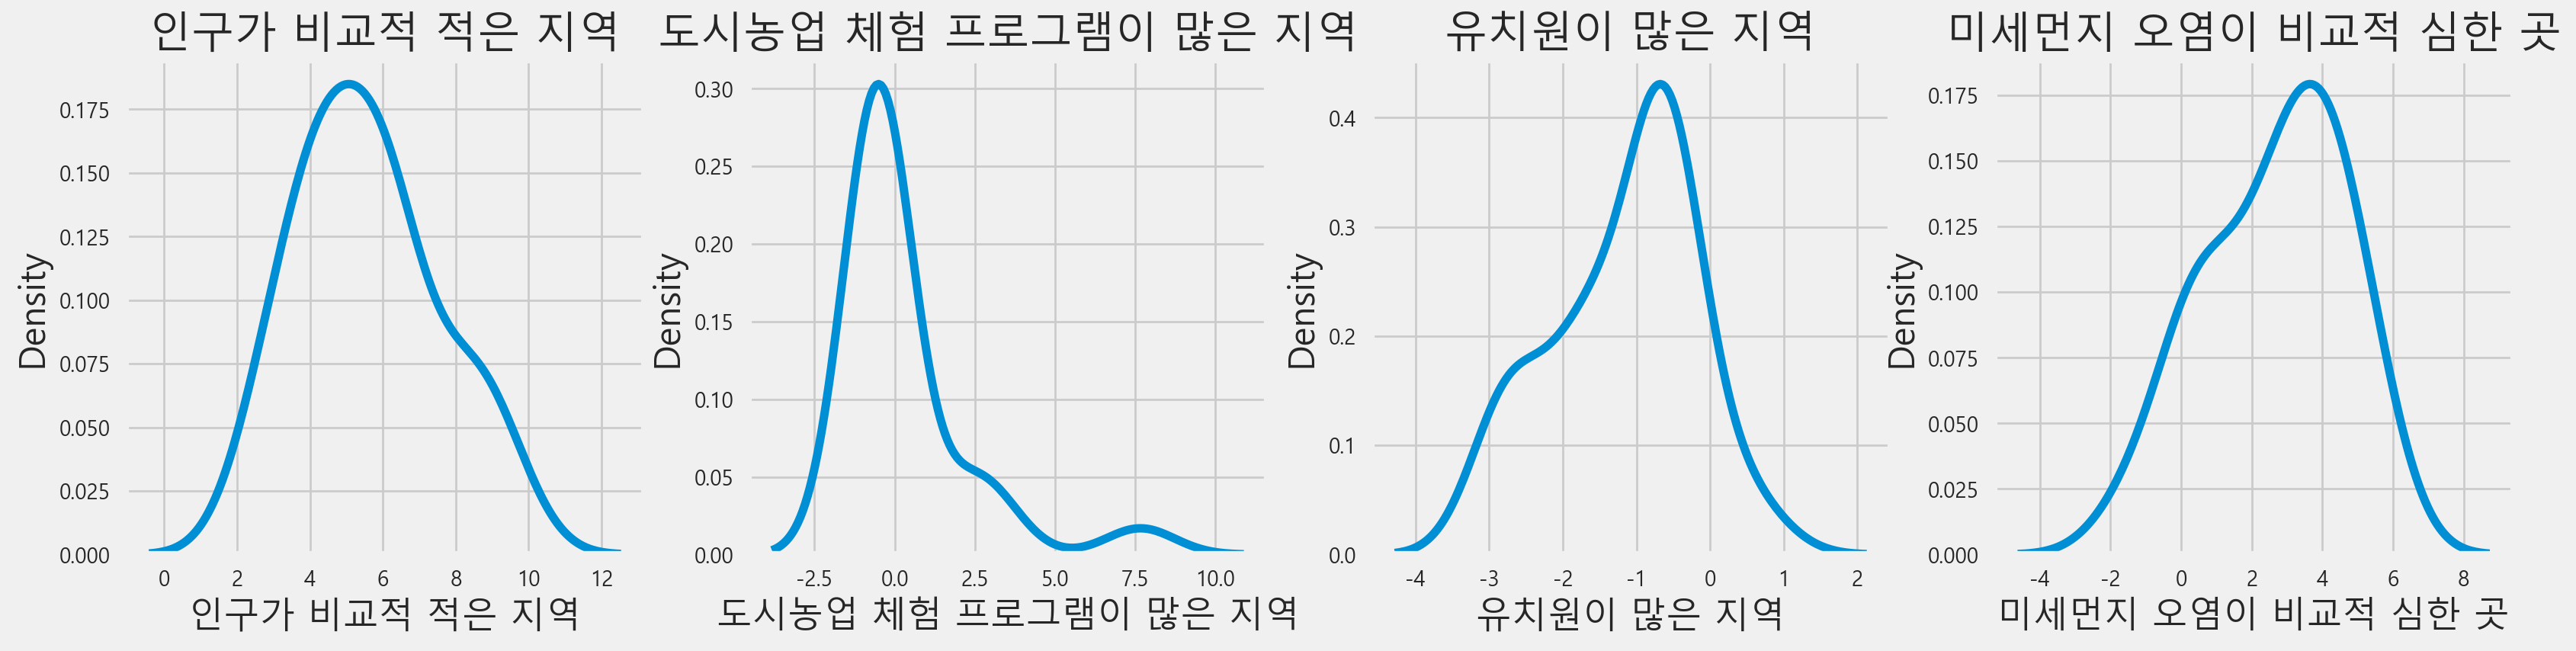

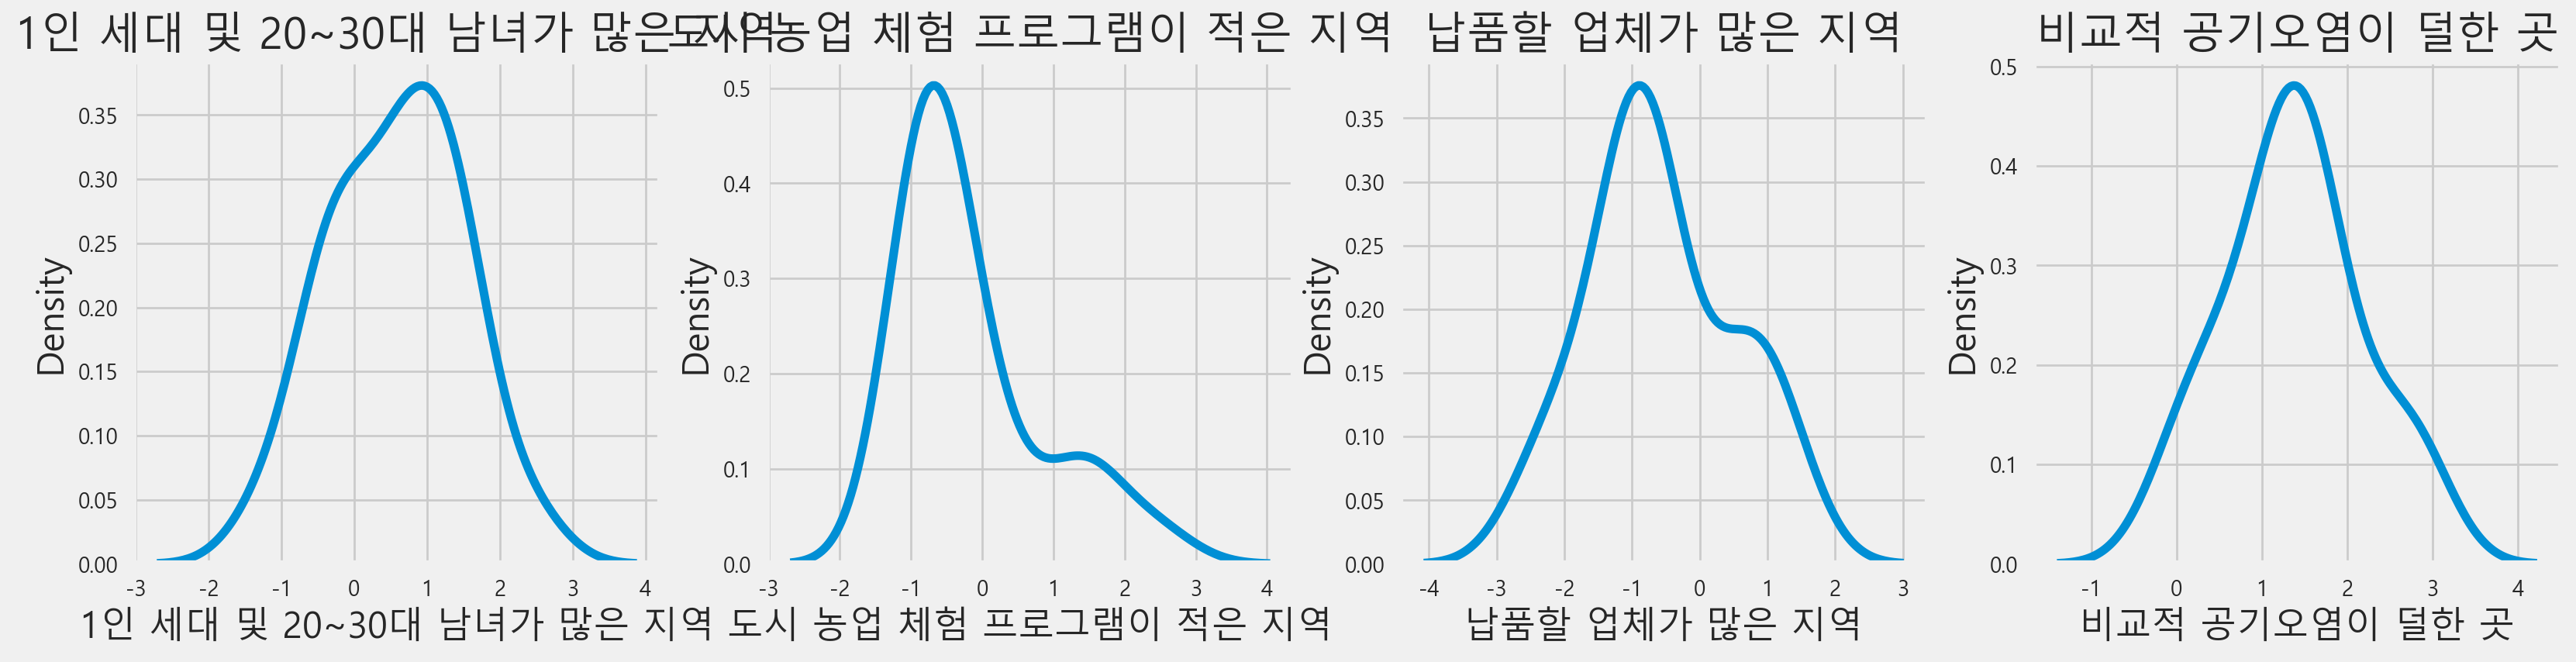

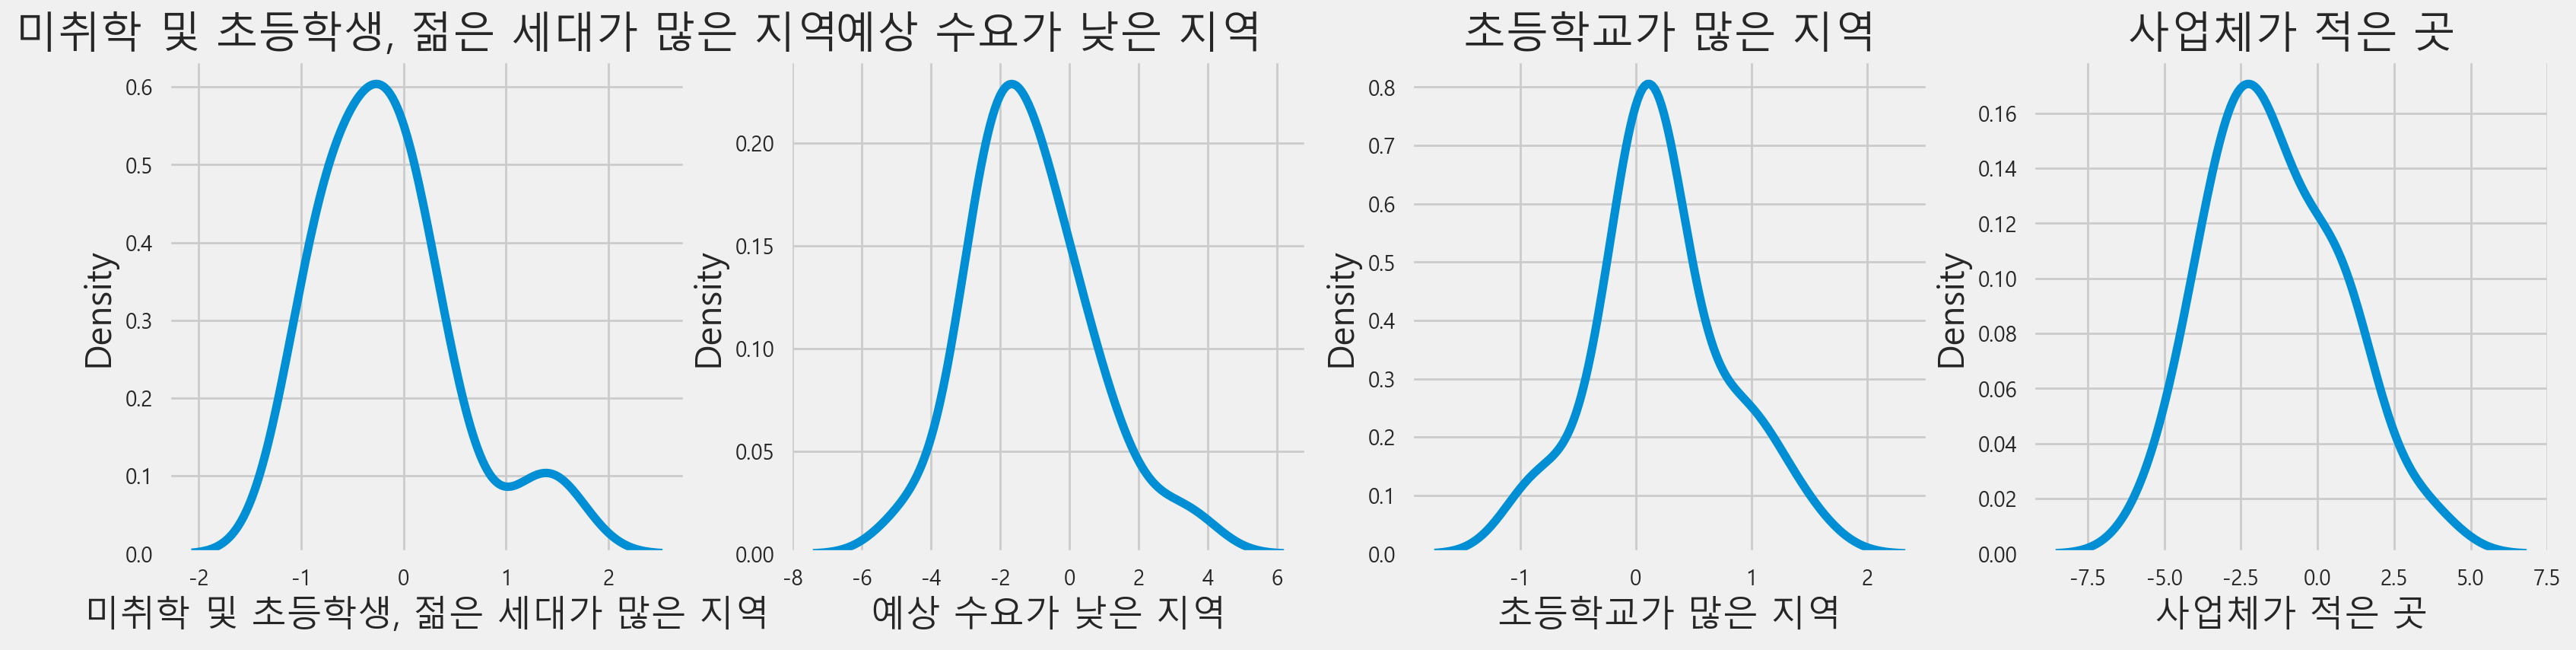

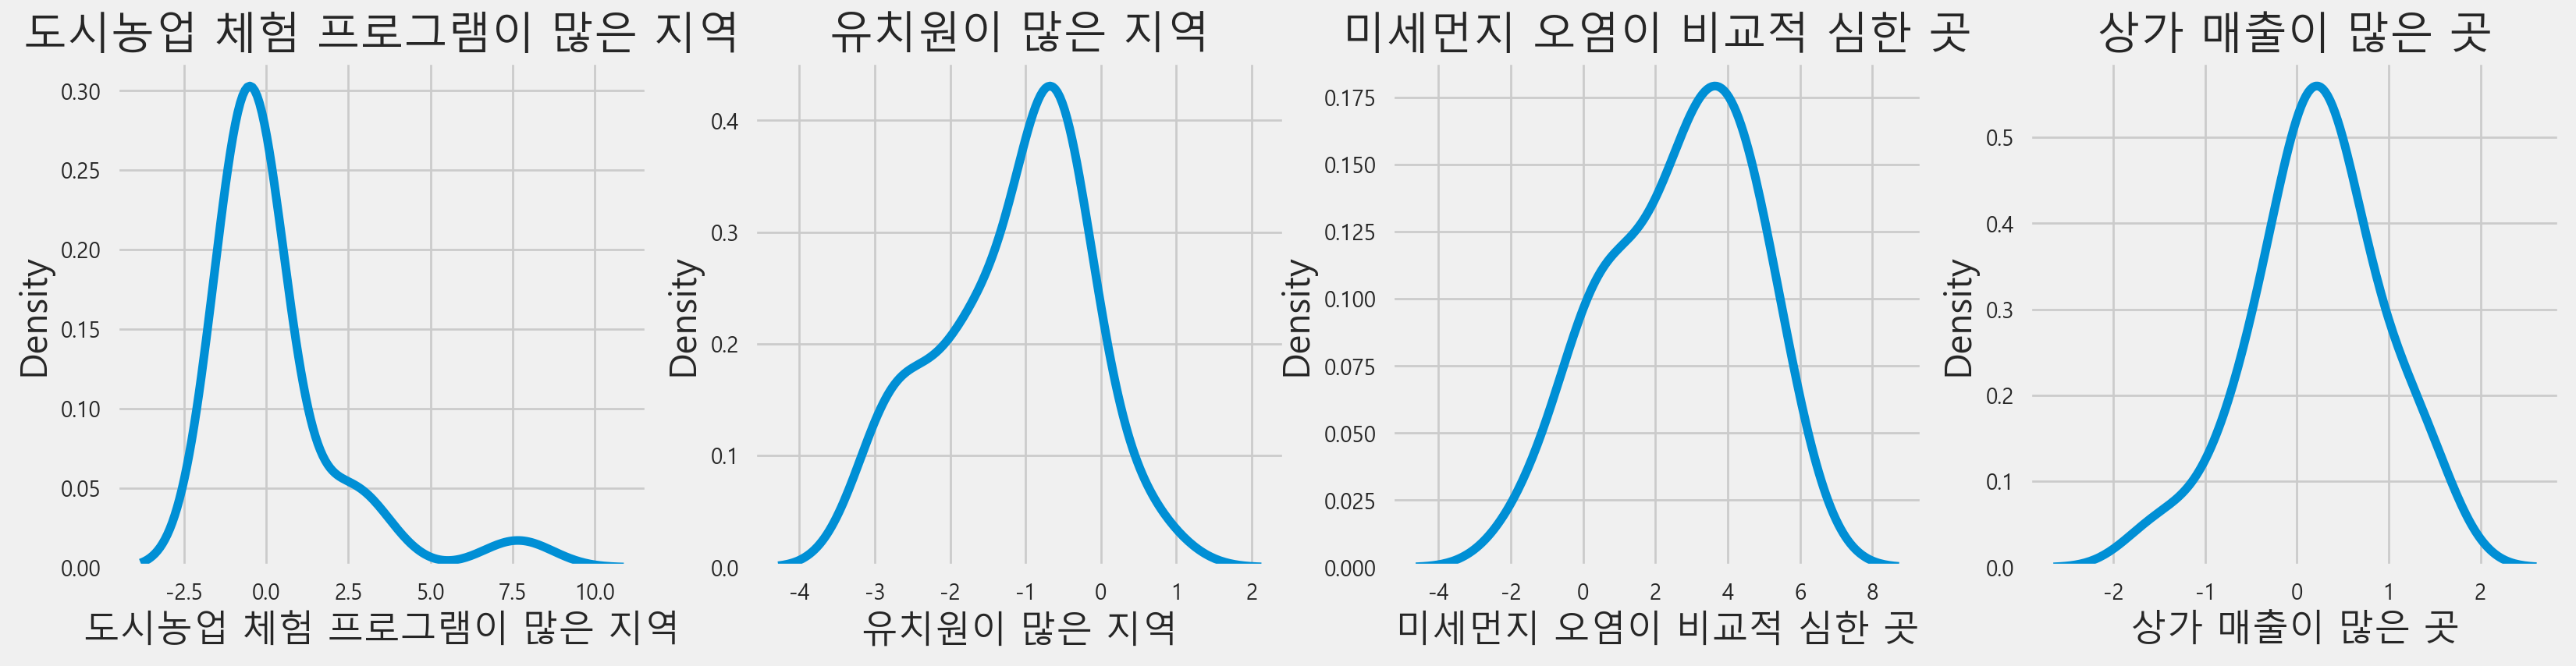

In [73]:
second_group = pca_result[pca_result['cluster'] == 1]
second_group.drop(['silhouette_coeff'], axis = 1, inplace = True)

for row_num in range(4) :
    histplot(second_group.drop(['cluster'], axis = 1), row_num, 4)

### 세번째 Group

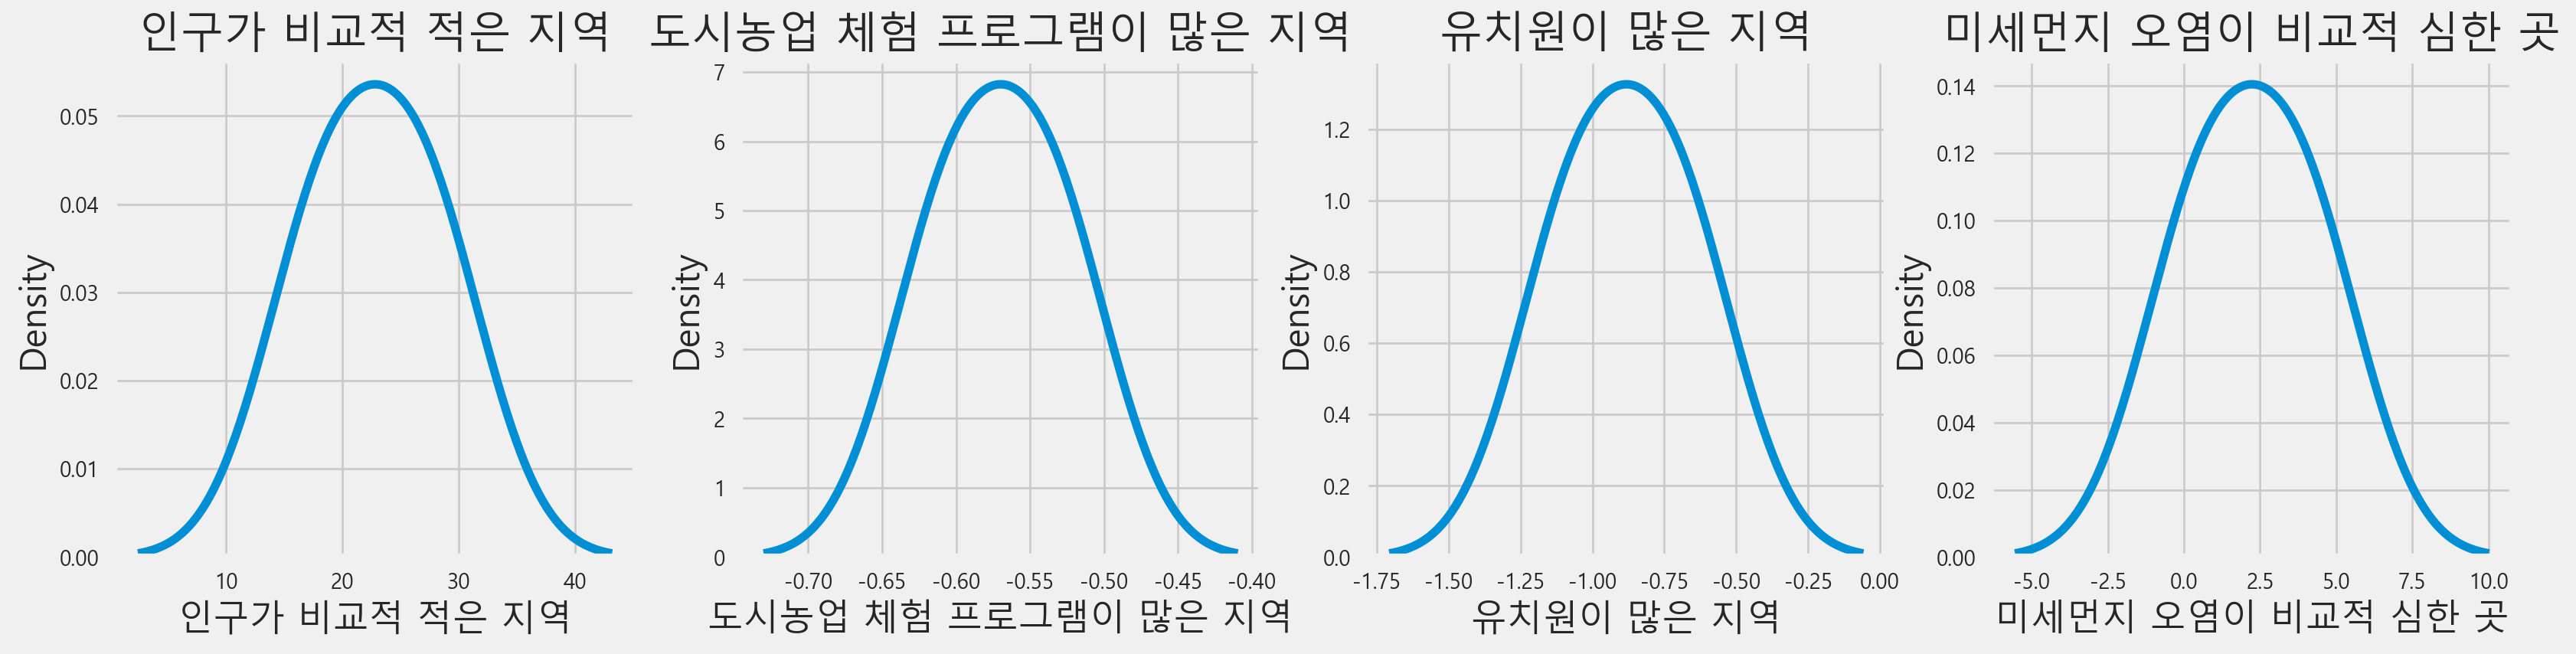

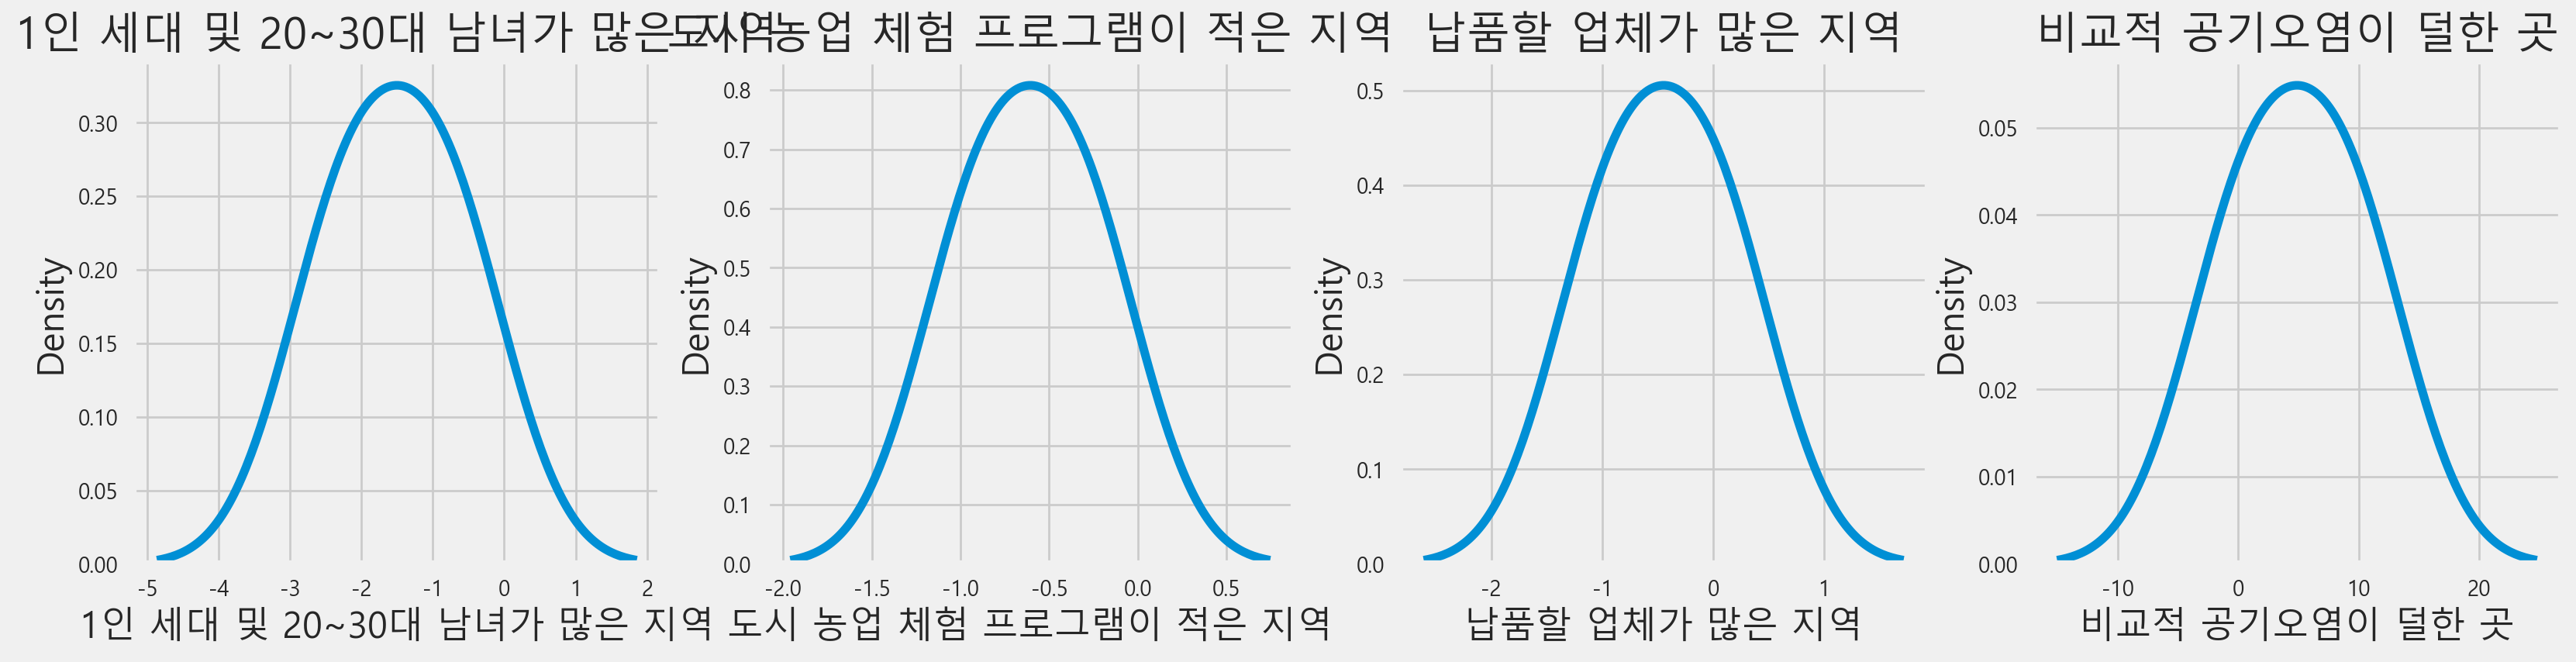

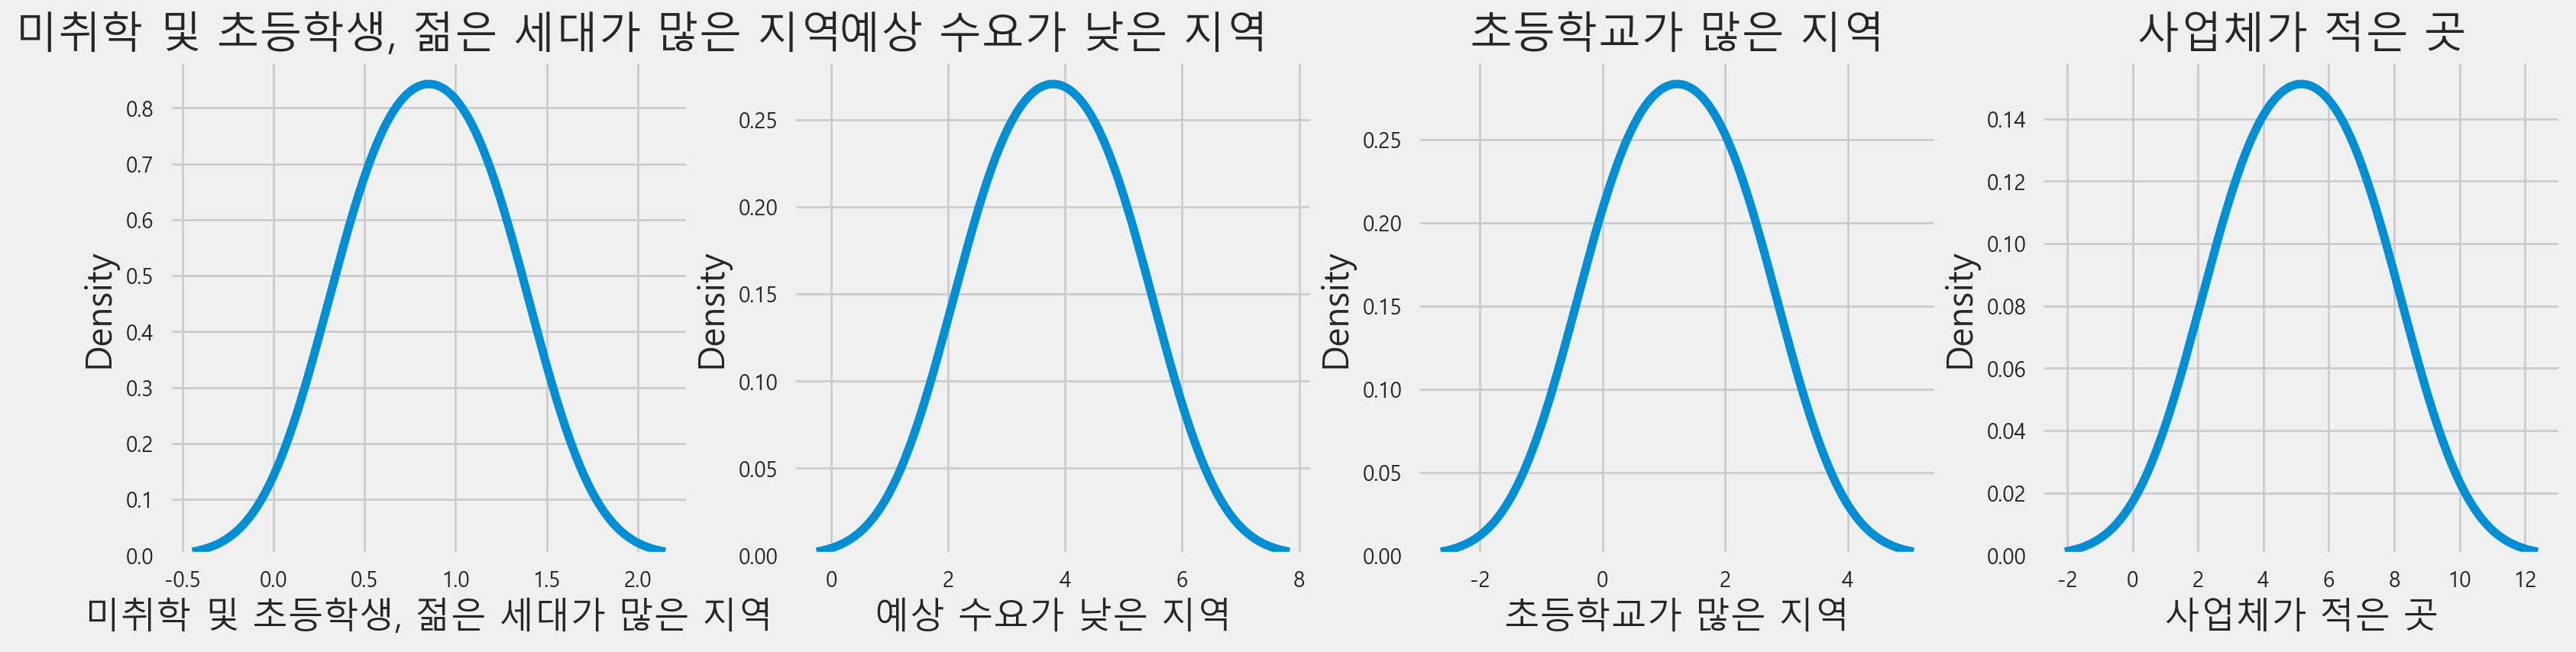

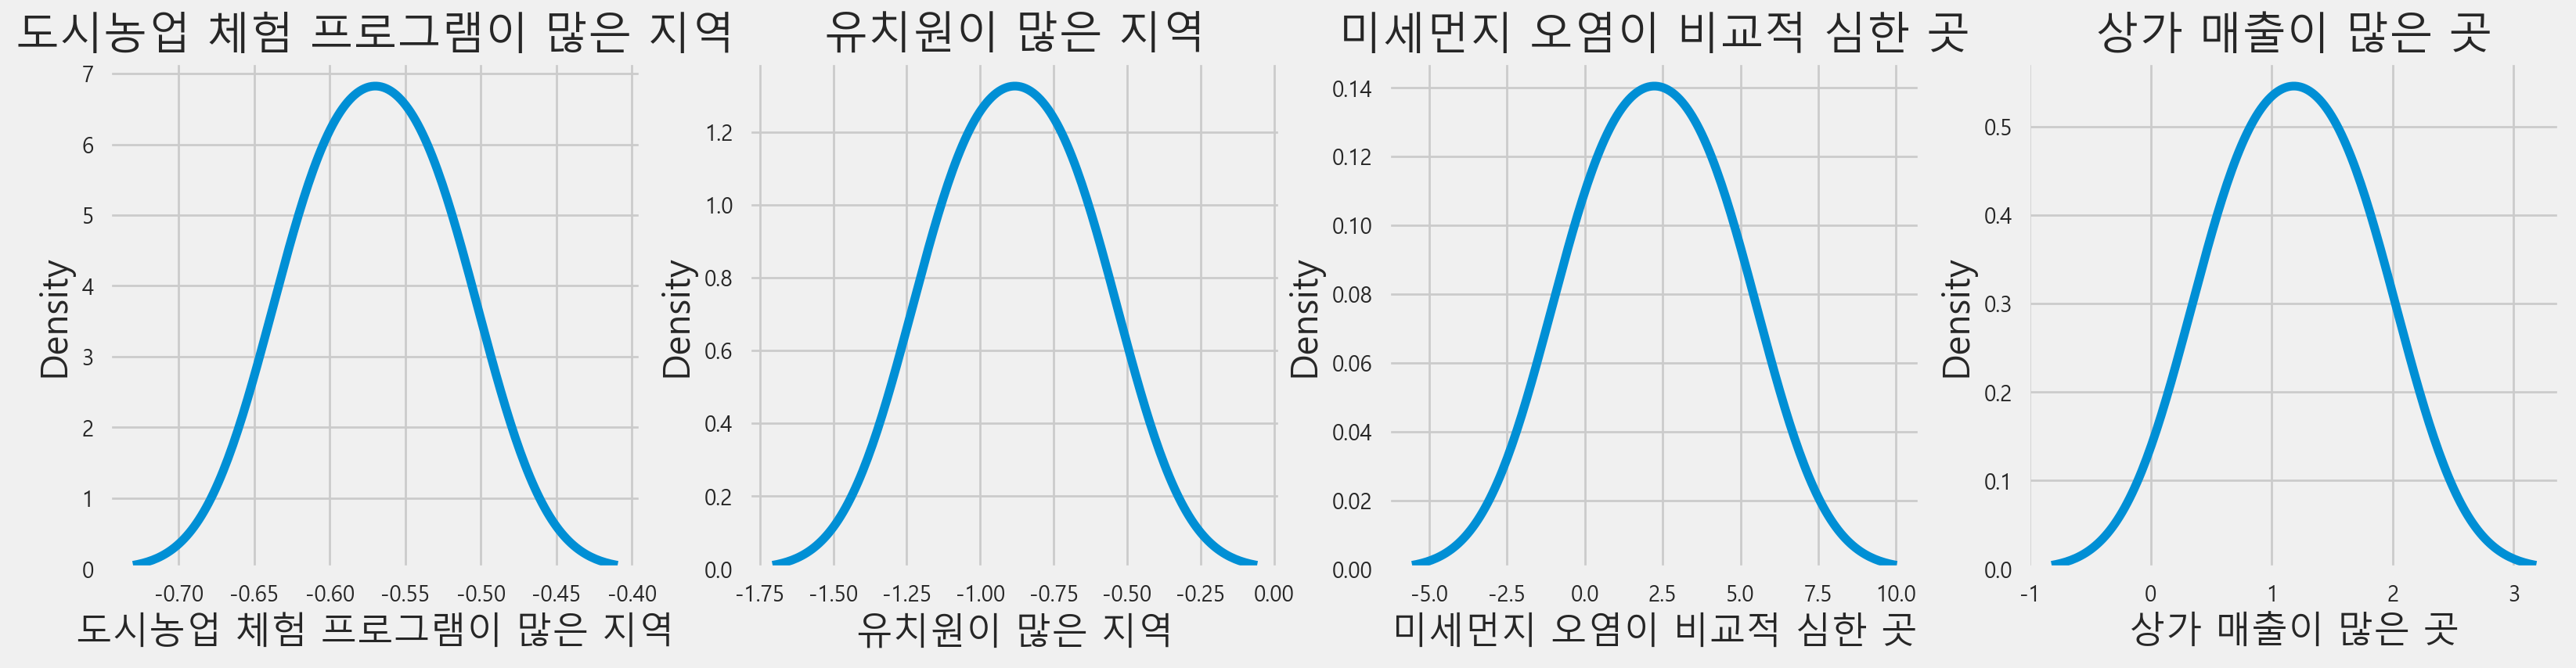

In [75]:
third_group = pca_result[pca_result['cluster'] == 2]
third_group.drop(['silhouette_coeff'], axis = 1, inplace = True)

for row_num in range(4) :
    histplot(third_group.drop(['cluster'], axis = 1), row_num, 4)

### 네번째 Group

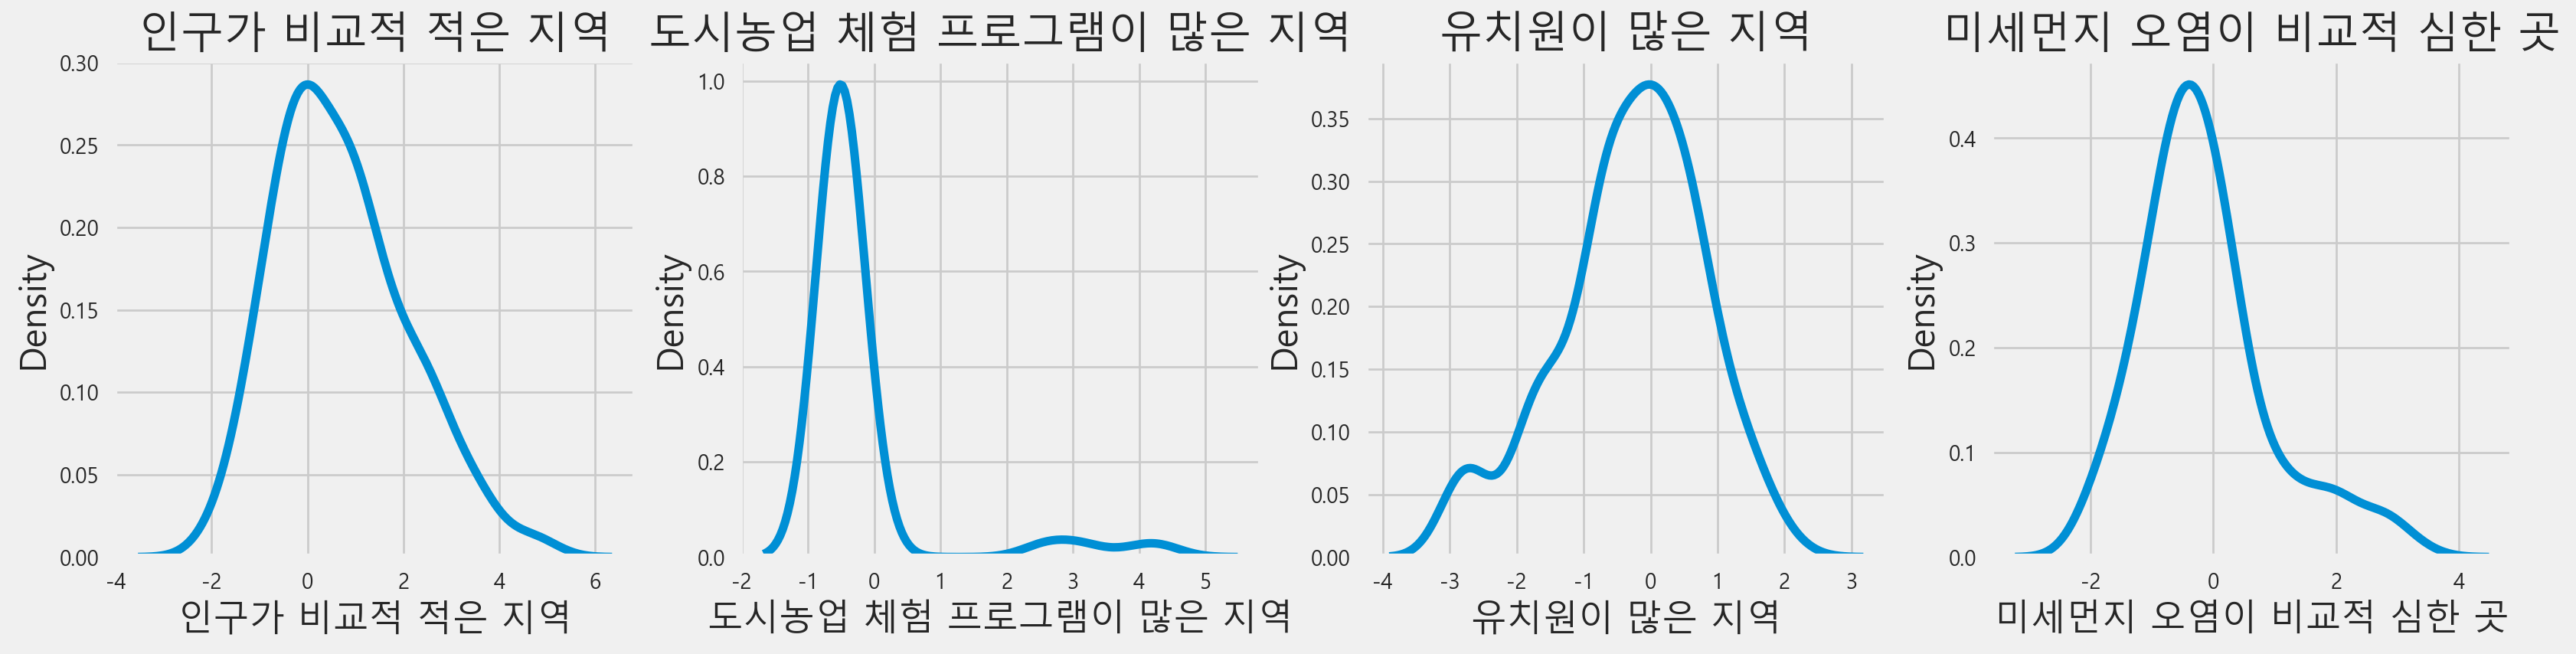

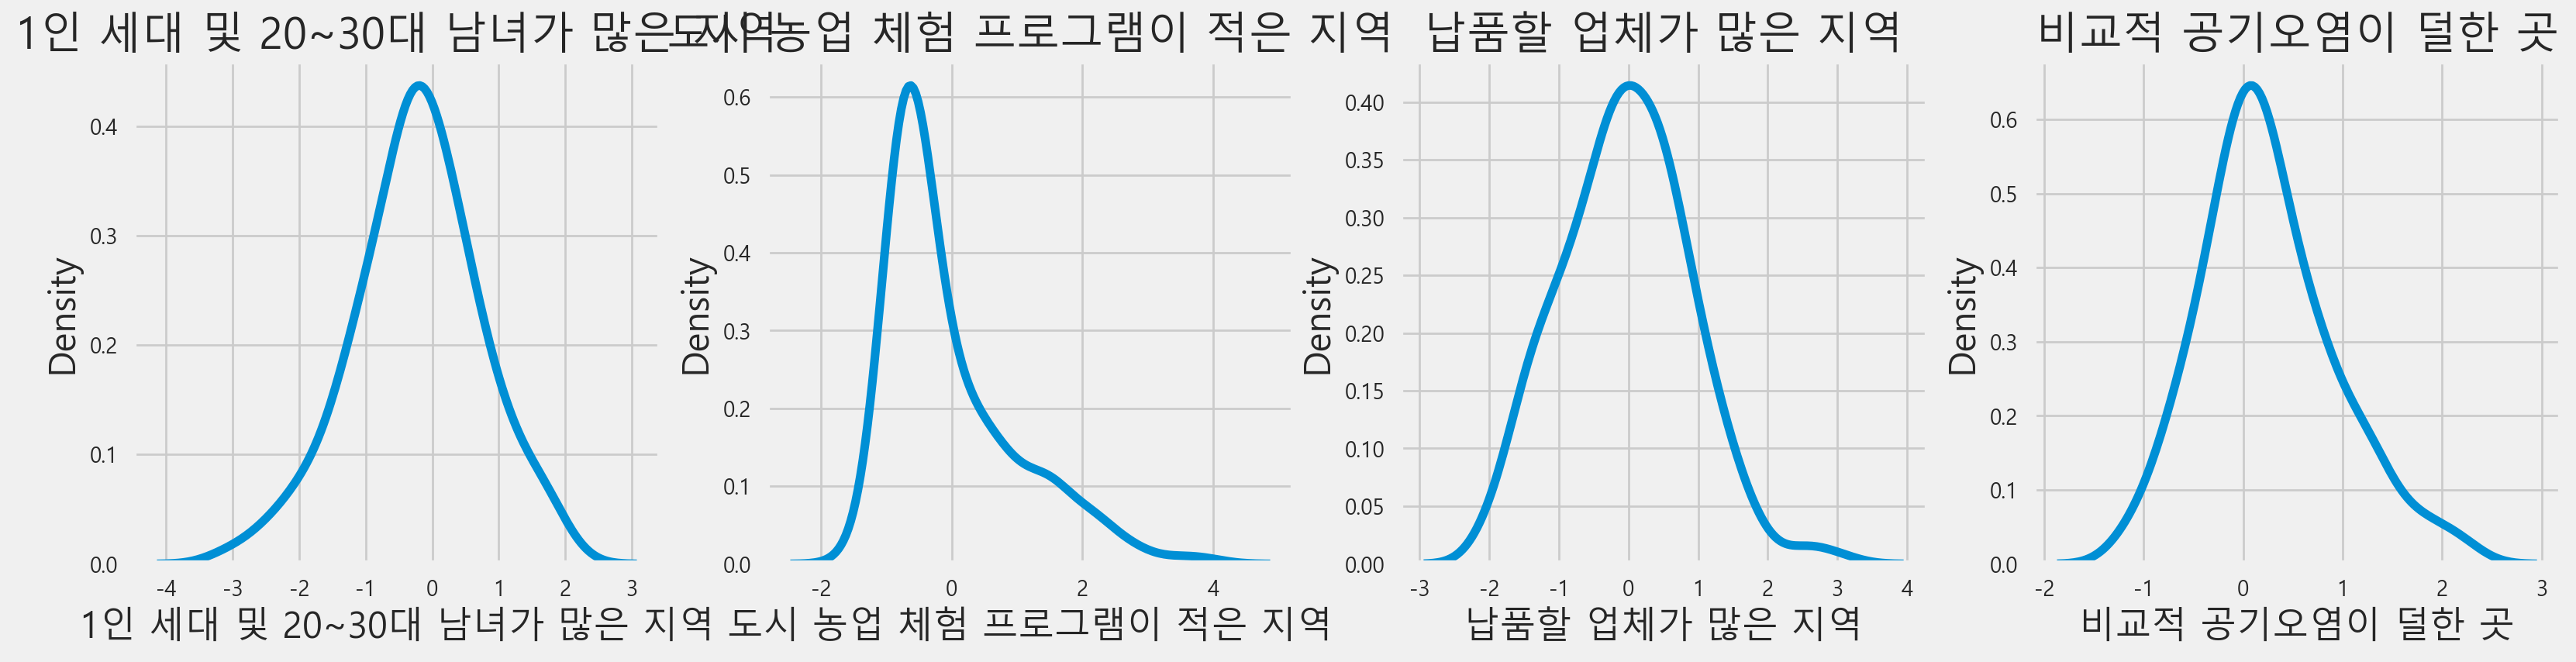

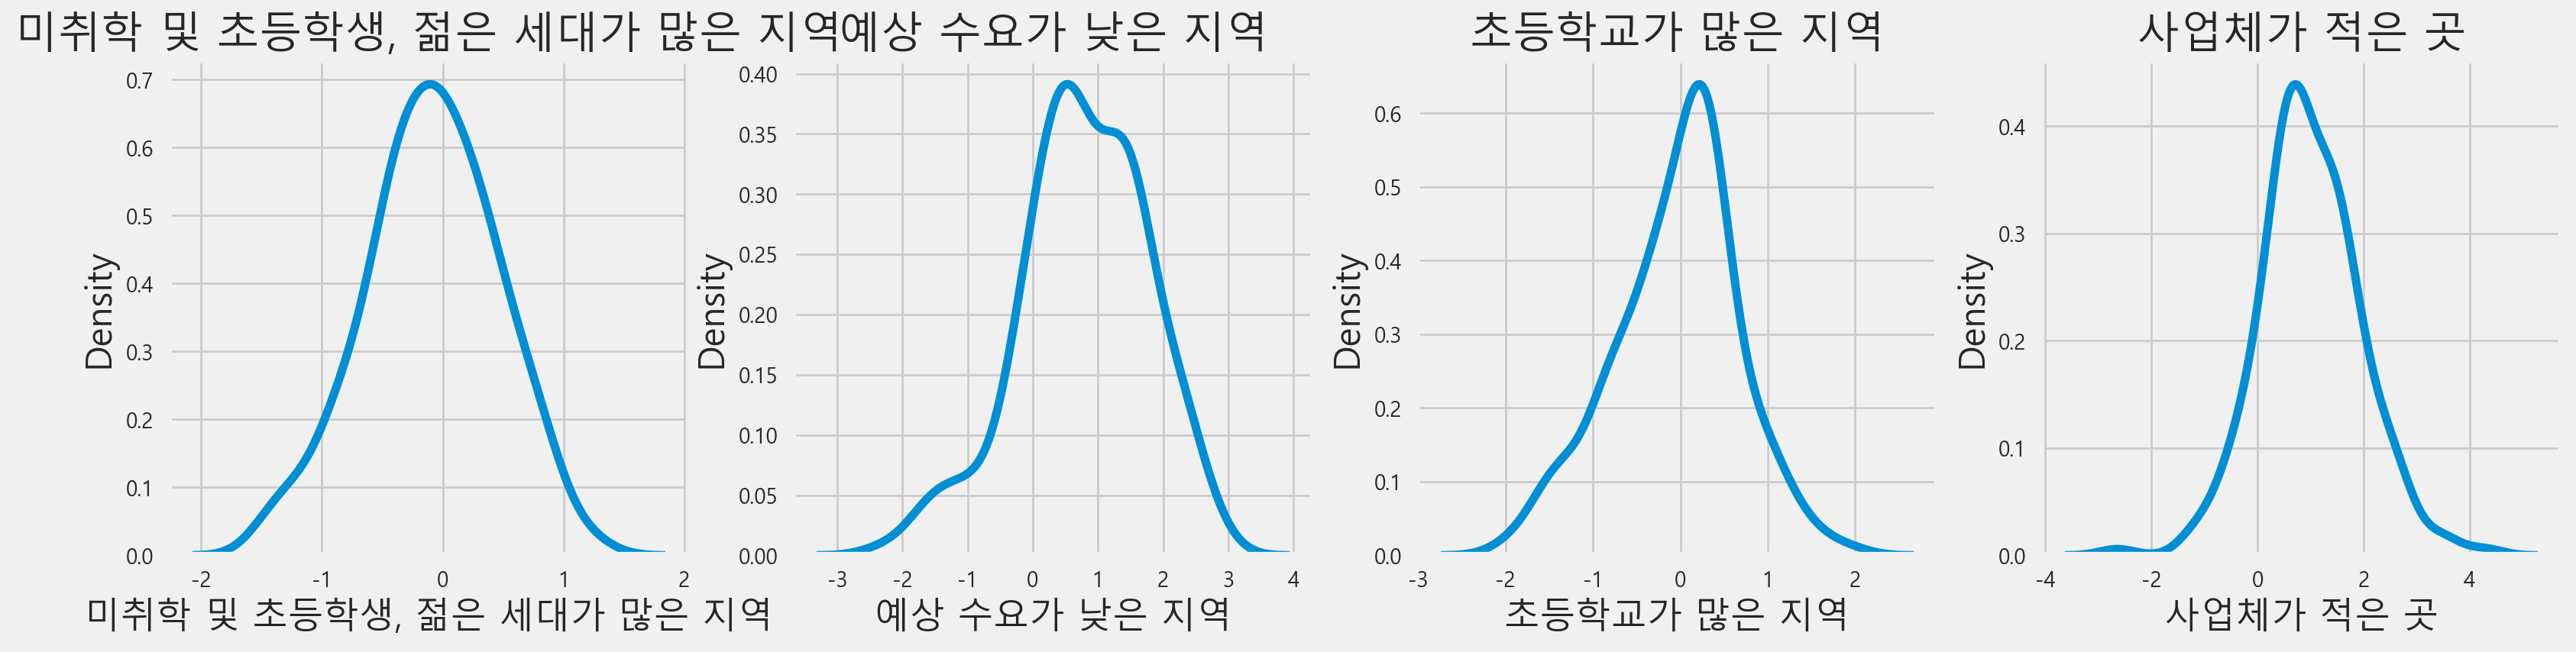

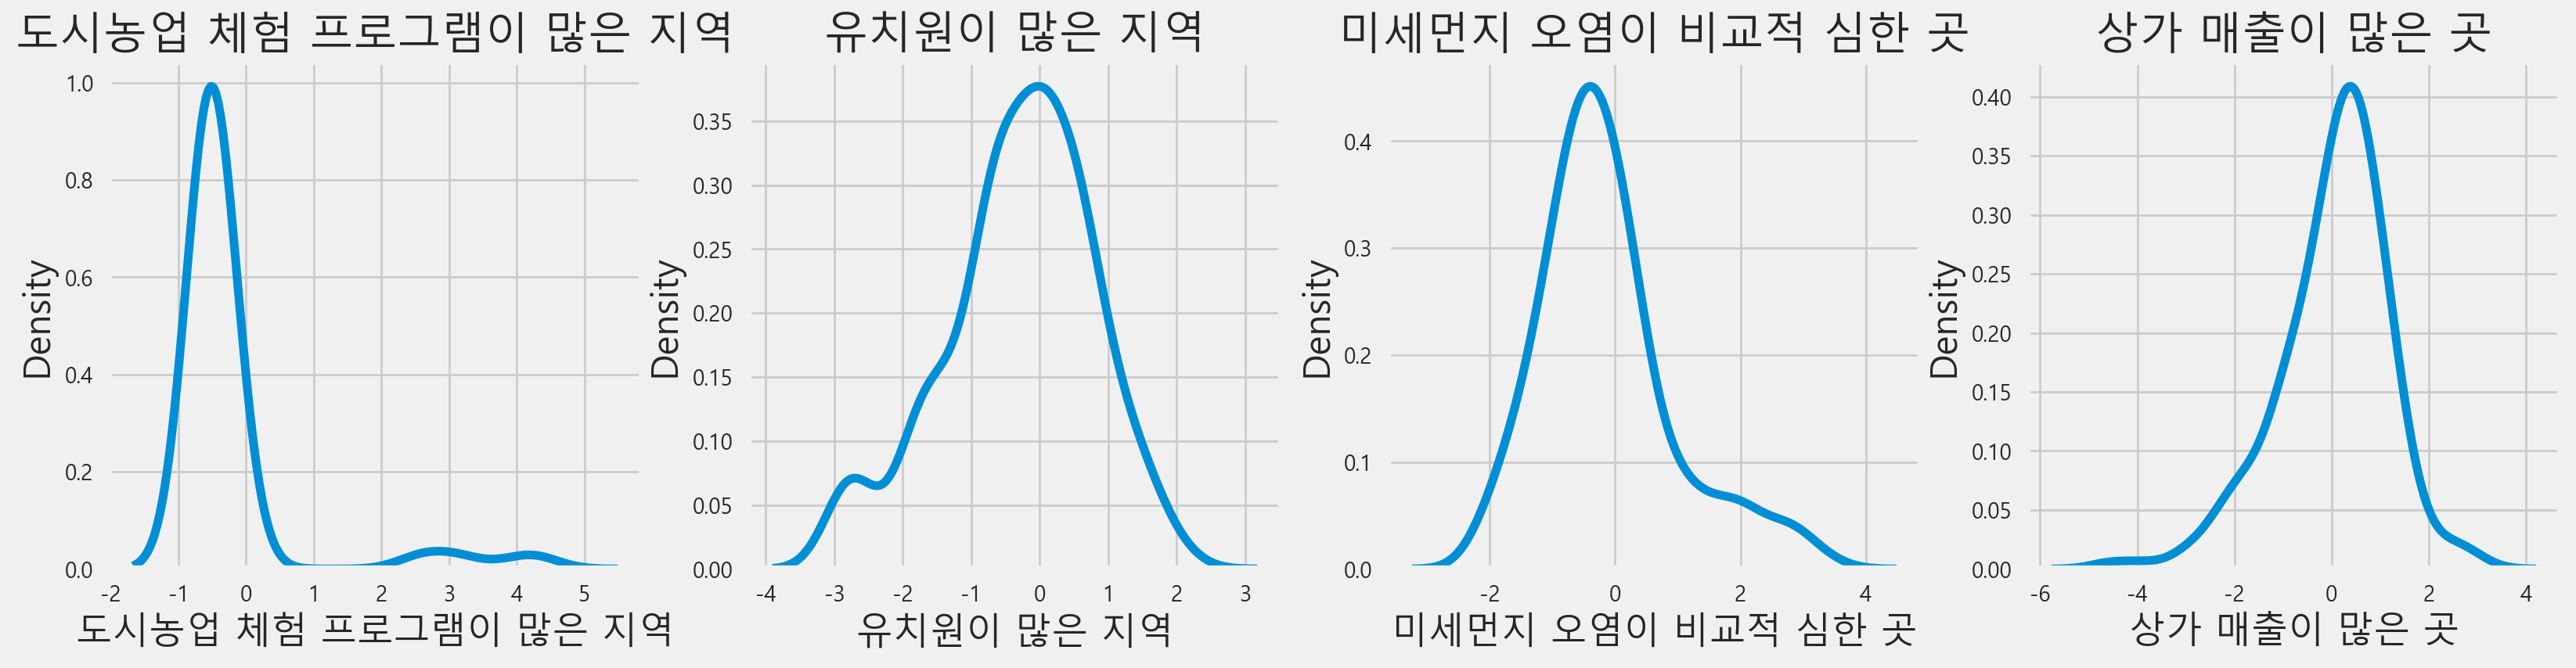

In [78]:
forth_group = pca_result[pca_result['cluster'] == 3]
forth_group.drop(['silhouette_coeff'], axis = 1, inplace = True)

for row_num in range(4) :
    histplot(forth_group.drop(['cluster'], axis = 1), row_num, 4)

In [82]:
cluster_0 = pca_result[pca_result['cluster'] == 0].index
cluster_1 = pca_result[pca_result['cluster'] == 1].index
cluster_2 = pca_result[pca_result['cluster'] == 2].index
cluster_3 = pca_result[pca_result['cluster'] == 3].index

In [84]:
cluster_3

Index(['가양2동', '가양3동', '갈현1동', '개봉2동', '개봉3동', '개포2동', '개포3동', '개포4동', '거여1동',
       '거여2동',
       ...
       '홍제2동', '홍제3동', '화곡2동', '화곡3동', '화곡4동', '황학동', '회기동', '효창동', '후암동',
       '휘경1동'],
      dtype='object', length=207)